In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv("data/movement-speeds-daily-san-francisco-2020-3.csv")

speeds_to_nodes

osm_start_node_id  osm_end_node_id  day  speed_mph_mean
0                   281266        702258940    1       59.674042
1                   281266        702274215    1       68.444042
2                   302876        240259516    1       66.446500
3                   302878        437325360    1       65.516850
4                   302883         65381191    1       61.880556
...                    ...              ...  ...             ...
1586647         6569140748       1350115374   31       68.484833
1586648         6570476556       4551993266   31       36.837000
1586649         6573249373       4911384010   31       39.021000
1586650         6573553681        256888796   31       68.728333
1586651         6577722252        209835741   31       68.905538

[1586652 rows x 4 columns]

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

This spatial structure will be effective in summarzing traffic speed since the area is not determined by a landmakrk/building/street address but a grid that locates each segment with a different codde and each segment having the same area.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"<node\sid=.(\d*).\slat=.(\d*\.\d*).\slon=.(.?\d*\.\d*).*>"

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

osm_node_id   Latitude   Longitude
0         26118026  37.675280 -122.389194
1         29891973  37.674935 -122.389130
2         29892598  37.716892 -122.398893
3         30033679  37.599877 -122.376497
4         30033686  37.642167 -122.405946
...            ...        ...         ...
19139   6522255428  37.760543 -122.443563
19140   6522255492  37.759317 -122.444996
19141   6522764204  37.762163 -122.436143
19142   6522764212  37.756061 -122.436761
19143   6522764213  37.761187 -122.440089

[19144 rows x 3 columns]

In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = node_to_gps.merge(speeds_to_nodes, how = "inner", left_on = "osm_node_id", right_on = "osm_start_node_id")
speeds_to_gps

osm_node_id   Latitude   Longitude  osm_start_node_id  \
0          26118026  37.675280 -122.389194           26118026   
1          26118026  37.675280 -122.389194           26118026   
2          26118026  37.675280 -122.389194           26118026   
3          26118026  37.675280 -122.389194           26118026   
4          26118026  37.675280 -122.389194           26118026   
...             ...        ...         ...                ...   
417634   6522764213  37.761187 -122.440089         6522764213   
417635   6522764213  37.761187 -122.440089         6522764213   
417636   6522764213  37.761187 -122.440089         6522764213   
417637   6522764213  37.761187 -122.440089         6522764213   
417638   6522764213  37.761187 -122.440089         6522764213   

        osm_end_node_id  day  speed_mph_mean  
0             259458979    1       64.478000  
1             259458979    2       62.868208  
2             259458979    3       62.211750  
3             259458979    4       62.192458  
4             259458979    5       61.913292  
...                 ...  ...             ...  
417634       6522255329   13       30.343462  
417635       6522255329   14       29.245500  
417636       6522255329   15       28.375333  
417637       6522255329   16       28.764250  
417638       6522255329   20       31.410000  

[417639 rows x 7 columns]

In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
speeds_to_gps["plus_latitude_idx"] = np.ceil(speeds_to_gps["Latitude"]/0.012).astype(int)
speeds_to_gps["plus_longitude_idx"] = np.ceil(speeds_to_gps["Longitude"]/0.012).astype(int) # do this however you like

speeds_to_gps

osm_node_id   Latitude   Longitude  osm_start_node_id  \
0          26118026  37.675280 -122.389194           26118026   
1          26118026  37.675280 -122.389194           26118026   
2          26118026  37.675280 -122.389194           26118026   
3          26118026  37.675280 -122.389194           26118026   
4          26118026  37.675280 -122.389194           26118026   
...             ...        ...         ...                ...   
417634   6522764213  37.761187 -122.440089         6522764213   
417635   6522764213  37.761187 -122.440089         6522764213   
417636   6522764213  37.761187 -122.440089         6522764213   
417637   6522764213  37.761187 -122.440089         6522764213   
417638   6522764213  37.761187 -122.440089         6522764213   

        osm_end_node_id  day  speed_mph_mean  plus_latitude_idx  \
0             259458979    1       64.478000               3140   
1             259458979    2       62.868208               3140   
2             259458979    3       62.211750               3140   
3             259458979    4       62.192458               3140   
4             259458979    5       61.913292               3140   
...                 ...  ...             ...                ...   
417634       6522255329   13       30.343462               3147   
417635       6522255329   14       29.245500               3147   
417636       6522255329   15       28.375333               3147   
417637       6522255329   16       28.764250               3147   
417638       6522255329   20       31.410000               3147   

        plus_longitude_idx  
0                   -10199  
1                   -10199  
2                   -10199  
3                   -10199  
4                   -10199  
...                    ...  
417634              -10203  
417635              -10203  
417636              -10203  
417637              -10203  
417638              -10203  

[417639 rows x 9 columns]

In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx']).size().reset_index().rename(columns={0:'count'}))
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



The plus codes does capture meaningful subpopulations since the subpopulations are divided into sectors with equal areas and the difference between the subpopulations outweigh the differences within the subpopulation because the value of across-cluster average of within-cluster standard deviation is less than  across-cluster standard deviation of within-cluster average speeds.
This means that there is a greater variance of average speed between different plus codes than the variance of average speed within the same unique plus code pair. 
These questions are important when assessing the quality of spatial clustering because if the variance within each cluster is greater than the varinace between different clusters, it indicates that subpopulations are not meaningful and there isn't sufficient variance between different subpopulations for us to extract relationships or outcomes.  

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

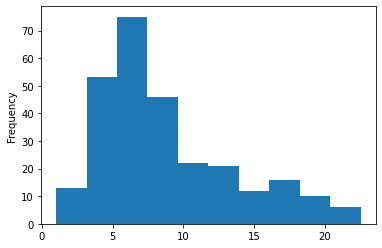

In [15]:
speed_variance_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx'])['speed_mph_mean'].std() # compute traffic speed variance in each plus code region
# plot a histogram
speed_variance_by_pluscode.plot.hist()
average_variance_by_pluscode = speed_variance_by_pluscode.mean()
variance_average_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx'])['speed_mph_mean'].mean().std()


<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

plus_latitude_idx  plus_longitude_idx
3129               -10209                 3.650232
                   -10197                20.704487
                   -10193                12.342234
3130               -10209                 4.083821
                   -10198                21.390912
                                           ...    
3161               -10197                15.293632
                   -10196                17.915911
                   -10195                14.243592
                   -10194                12.237229
                   -10193                17.590817
Name: speed_mph_mean, Length: 276, dtype: float64

In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

MOVEMENT_ID                                       DISPLAY_NAME  \
0               1                            Sargent Creek, San Ardo   
1               2  400 Northumberland Avenue, Redwood Oaks, Redwo...   
2               3                18300 Sutter Boulevard, Morgan Hill   
3               4          2700 Stoughton Way, Sheffield, Sacramento   
4               5     3200 Huntsman Drive, Rosemont Park, Sacramento   
...           ...                                                ...   
2705         2706                     10000 Bobbell Drive, Elk Grove   
2706         2707                        400 Ericwood Court, Manteca   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2708         2709                1200 Halyard Drive, West Sacramento   
2709         2710   2500 Clubhouse Drive West, Whitney Oaks, Rocklin   

                                               geometry  
0     MULTIPOLYGON (((-121.59511 36.11126, -121.5401...  
1     MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
2     MULTIPOLYGON (((-121.67978 37.15859, -121.6719...  
3     MULTIPOLYGON (((-121.35921 38.57175, -121.3462...  
4     MULTIPOLYGON (((-121.37512 38.55309, -121.3715...  
...                                                 ...  
2705  MULTIPOLYGON (((-121.48392 38.40874, -121.4787...  
2706  MULTIPOLYGON (((-121.22695 37.82647, -121.2185...  
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...  
2708  MULTIPOLYGON (((-121.58346 38.57860, -121.5827...  
2709  MULTIPOLYGON (((-121.25720 38.82472, -121.2545...  

[2710 rows x 3 columns]

In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude), crs = "EPSG:4326")
speeds_to_tract = tract_to_gps.sjoin(speeds_to_points)

speeds_to_tract

MOVEMENT_ID                                       DISPLAY_NAME  \
8               9         500 Hyde Street, Tenderloin, San Francisco   
8               9         500 Hyde Street, Tenderloin, San Francisco   
8               9         500 Hyde Street, Tenderloin, San Francisco   
8               9         500 Hyde Street, Tenderloin, San Francisco   
8               9         500 Hyde Street, Tenderloin, San Francisco   
...           ...                                                ...   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   

                                               geometry  index_right  \
8     MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       375185   
8     MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       375182   
8     MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       375186   
8     MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       375187   
8     MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       375188   
...                                                 ...          ...   
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       163943   
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       163958   
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       210011   
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       285866   
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       285865   

      osm_node_id   Latitude   Longitude  osm_start_node_id  osm_end_node_id  \
8      5429620647  37.784356 -122.416866         5429620647         65333834   
8      5429620647  37.784356 -122.416866         5429620647         65333834   
8      5429620647  37.784356 -122.416866         5429620647         65333834   
8      5429620647  37.784356 -122.416866         5429620647         65333834   
8      5429620647  37.784356 -122.416866         5429620647         65333834   
...           ...        ...         ...                ...              ...   
2707     65436480  37.661119 -122.438615           65436480       4552055202   
2707     65436480  37.661119 -122.438615           65436480       4552055202   
2707    267053289  37.663610 -122.441970          267053289       5435703115   
2707   2278938365  37.664004 -122.442453         2278938365        267053289   
2707   2278938365  37.664004 -122.442453         2278938365        267053289   

      day  speed_mph_mean  plus_latitude_idx  plus_longitude_idx  
8      15        8.073692               3149              -10201  
8      12        8.373600               3149              -10201  
8      16        4.390000               3149              -10201  
8      17        5.634000               3149              -10201  
8      28       22.594000               3149              -10201  
...   ...             ...                ...                 ...  
2707    5       22.683500               3139              -10203  
2707   16       23.532000               3139              -10203  
2707    7       21.980333               3139              -10203  
2707    9       10.968000               3139              -10203  
2707    3       12.112500               3139              -10203  

[418848 rows x 13 columns]

In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby("MOVEMENT_ID")["speed_mph_mean"].mean()
num_census_tracts = len(speeds_by_tract)
...
num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



The census tract does not capture meaningful subpopulations because the difference between the subpopulations does not outweigh the differences within the subpopulation since the value of across-cluster average of within-cluster standard deviation is almost equal to across-cluster standard deviation of within-cluster average speeds.
This means that the variance of average speed within each census tract is almost identical to the variance of average speed between different census tracts which makes each subpopulation meaningless.
The average standard deviation is low since the variance is similar within all locations within and outside of each census tract.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

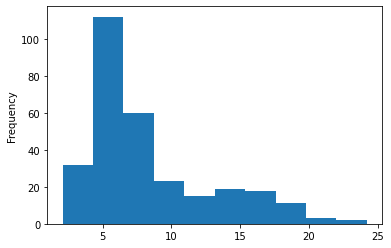

In [24]:
speed_variance_by_tract = speeds_to_tract.groupby("MOVEMENT_ID")["speed_mph_mean"].std()
speed_variance_by_tract.plot.hist()
average_variance_by_tract = np.mean(speed_variance_by_tract)
variance_average_by_tract = np.std(speeds_to_tract.groupby("MOVEMENT_ID")["speed_mph_mean"].mean())

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [25]:
speed_variance_by_tract

MOVEMENT_ID
9        3.821144
20       5.522853
21       3.640453
44       6.634154
78       3.838873
          ...    
2691     3.379664
2694     5.787065
2695     4.617596
2700    13.191079
2708     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [26]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

I think a good metric for spatial structure is verifying whether we can derive meaningful conclusions or relations by comparing between different subpopulations of the spatial structure and validating that the variance between different subpopulations are greater than the variance within each subpopulation. It should also divide each subpopulation in a way that each subpopulation has the same way of defining each section such as using a grid or a certain shape to set the subpopulation.
In order to optimize my own metrics, I would use a combination of plus codes and Traffic Analysis Zones. I would create spatial clustering based on the grid of the plus codes but differentiate the area of the codes captured for each subgroup to account for the census data of the Traffic Analysis. 
Some plus-code regions will have a greater area (multiple plus codes areas grouped into one) to account for the similarity in variance of the region whereas other plus-code regions will have a smaller area to distinguish the areas with high variance between each other.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [27]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract[speeds_to_tract["day"] <= 13].groupby("DISPLAY_NAME")["speed_mph_mean"].mean()  
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = speeds_to_tract[speeds_to_tract["day"] <= 13].groupby("MOVEMENT_ID").agg({"DISPLAY_NAME" : lambda x : x.iloc[0], "geometry" : lambda x : x.iloc[0], "speed_mph_mean" : np.mean}).reset_index(drop=True)
averages_pre_named

DISPLAY_NAME  \
0           500 Hyde Street, Tenderloin, San Francisco   
1     900 Sutter Street, Lower Nob Hill, San Francisco   
2    3400 Pierce Street, Marina District, San Franc...   
3           1700 Egbert Avenue, Bayview, San Francisco   
4           1400 Thomas Avenue, Bayview, San Francisco   
..                                                 ...   
290                         800 Hacienda Way, Millbrae   
291  1900 Buchanan Street, Western Addition, San Fr...   
292  2200 Rivera Street, Sunset District, San Franc...   
293    300 Ponderosa Road, Avalon, South San Francisco   
294  200 Westview Drive, Sunshine Gardens, South Sa...   

                                              geometry  speed_mph_mean  
0    MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       14.585102  
1    MULTIPOLYGON (((-122.42208 37.78847, -122.4153...       15.679922  
2    MULTIPOLYGON (((-122.44191 37.80374, -122.4371...       14.292445  
3    MULTIPOLYGON (((-122.40211 37.72779, -122.3998...       23.353083  
4    MULTIPOLYGON (((-122.39270 37.72928, -122.3918...       16.213552  
..                                                 ...             ...  
290  MULTIPOLYGON (((-122.42288 37.60714, -122.4187...       20.746333  
291  MULTIPOLYGON (((-122.43549 37.78870, -122.4338...       17.042386  
292  MULTIPOLYGON (((-122.49505 37.74968, -122.4858...       20.029011  
293  MULTIPOLYGON (((-122.44834 37.64598, -122.4460...       32.184422  
294  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       24.822808  

[295 rows x 3 columns]

In [28]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [29]:
bottom10_averages_pre = averages_pre_named.sort_values("speed_mph_mean").head(10)
bottom10_averages_pre

DISPLAY_NAME  \
166    200 O'Farrell Street, Tenderloin, San Francisco   
249          0 Mason Street, Tenderloin, San Francisco   
163        1100 Taylor Street, Nob Hill, San Francisco   
59   2900 22nd Street, Mission District, San Francisco   
51        200 Myrtle Street, Tenderloin, San Francisco   
164  200 Sutter Street, Financial District, San Fra...   
99        800 Jackson Street, Chinatown, San Francisco   
100        500 Geary Street, Tenderloin, San Francisco   
52         200 Jones Street, Tenderloin, San Francisco   
158         200 Hyde Street, Tenderloin, San Francisco   

                                              geometry  speed_mph_mean  
166  MULTIPOLYGON (((-122.41462 37.78558, -122.4129...       12.417079  
249  MULTIPOLYGON (((-122.41405 37.78279, -122.4107...       12.595120  
163  MULTIPOLYGON (((-122.41629 37.79389, -122.4152...       12.945291  
59   MULTIPOLYGON (((-122.41672 37.75717, -122.4123...       13.195865  
51   MULTIPOLYGON (((-122.42146 37.78663, -122.4182...       13.490311  
164  MULTIPOLYGON (((-122.40879 37.79016, -122.4071...       13.502505  
99   MULTIPOLYGON (((-122.41172 37.79629, -122.4084...       13.549474  
100  MULTIPOLYGON (((-122.41500 37.78745, -122.4133...       13.570625  
52   MULTIPOLYGON (((-122.41443 37.78466, -122.4127...       13.626251  
158  MULTIPOLYGON (((-122.41771 37.78424, -122.4160...       13.944773

In [30]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [31]:
top10_averages_pre = averages_pre_named.sort_values("speed_mph_mean", ascending = False).head(10)
top10_averages_pre

DISPLAY_NAME  \
23                       1600 Maritime Street, Oakland   
36                  4200 Shelter Creek Lane, San Bruno   
155                         Petrolite Street, Richmond   
248               Frenchmans Creek Road, Half Moon Bay   
199                         1200 Helen Drive, Millbrae   
231  0 Crystal Springs Terrace, Hillsborough Park, ...   
288                         0 Burgess Court, Sausalito   
222                        Liccicitos Road, Moss Beach   
191              0 Longview Drive, Westlake, Daly City   
198               600 San Bruno Avenue East, San Bruno   

                                              geometry  speed_mph_mean  
23   MULTIPOLYGON (((-122.33037 37.82058, -122.3161...       59.498552  
36   MULTIPOLYGON (((-122.43101 37.61999, -122.4300...       53.867847  
155  MULTIPOLYGON (((-122.42976 37.96540, -122.4185...       47.318340  
248  MULTIPOLYGON (((-122.46816 37.56079, -122.4605...       47.225137  
199  MULTIPOLYGON (((-122.42820 37.60497, -122.4263...       45.492292  
231  MULTIPOLYGON (((-122.37189 37.54776, -122.3710...       44.304919  
288  MULTIPOLYGON (((-122.52032 37.87046, -122.5193...       43.848188  
222  MULTIPOLYGON (((-122.52036 37.57534, -122.5180...       42.784267  
191  MULTIPOLYGON (((-122.50053 37.70083, -122.4961...       40.587037  
198  MULTIPOLYGON (((-122.41676 37.63935, -122.4115...       38.944079

In [32]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

<AxesSubplot:ylabel='Frequency'>

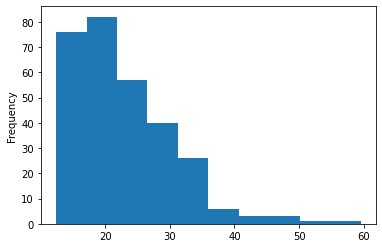

In [33]:
averages_pre.plot.hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [34]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("DISPLAY_NAME")["speed_mph_mean"].mean() 
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID").agg({"DISPLAY_NAME" : lambda x : x.iloc[0], "geometry" : lambda x : x.iloc[0], "speed_mph_mean" : np.mean}).reset_index(drop=True)
averages_post_named

DISPLAY_NAME  \
0           500 Hyde Street, Tenderloin, San Francisco   
1     900 Sutter Street, Lower Nob Hill, San Francisco   
2    3400 Pierce Street, Marina District, San Franc...   
3           1700 Egbert Avenue, Bayview, San Francisco   
4           1400 Thomas Avenue, Bayview, San Francisco   
..                                                 ...   
280                         800 Hacienda Way, Millbrae   
281  1900 Buchanan Street, Western Addition, San Fr...   
282  2200 Rivera Street, Sunset District, San Franc...   
283    300 Ponderosa Road, Avalon, South San Francisco   
284  200 Westview Drive, Sunshine Gardens, South Sa...   

                                              geometry  speed_mph_mean  
0    MULTIPOLYGON (((-122.41827 37.78704, -122.4150...       16.143154  
1    MULTIPOLYGON (((-122.42208 37.78847, -122.4153...       16.871488  
2    MULTIPOLYGON (((-122.44191 37.80374, -122.4371...       15.754795  
3    MULTIPOLYGON (((-122.40211 37.72779, -122.3998...       25.956602  
4    MULTIPOLYGON (((-122.39270 37.72928, -122.3918...       16.476000  
..                                                 ...             ...  
280  MULTIPOLYGON (((-122.42288 37.60714, -122.4187...       17.917000  
281  MULTIPOLYGON (((-122.43549 37.78870, -122.4338...       22.128519  
282  MULTIPOLYGON (((-122.49505 37.74968, -122.4858...       23.440404  
283  MULTIPOLYGON (((-122.44834 37.64598, -122.4460...       38.807594  
284  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...       26.171347  

[285 rows x 3 columns]

In [35]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

<AxesSubplot:ylabel='Frequency'>

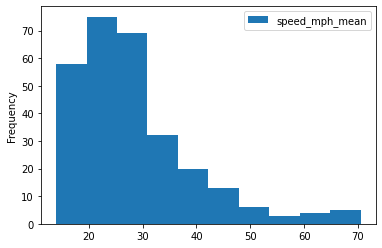

In [36]:
averages_post_named.plot.hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

In [37]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = differences = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID")["speed_mph_mean"].mean() - speeds_to_tract[speeds_to_tract["day"] <= 13].groupby("MOVEMENT_ID")["speed_mph_mean"].mean() 
# plot the differences

In [38]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

<AxesSubplot:xlabel='day'>

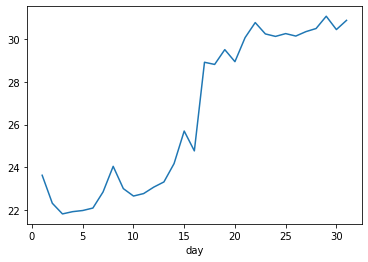

In [39]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby("day")["speed_mph_mean"].mean()
speeds_daily.plot.line()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

The change in speed has a very sudden increase near day 16 where the average speed jumps from 22~24 around 30. This may be due to the fact that Governor Gavin Newsom ordered all bars, nightclubs, wineries, and brewpubs to close, tells adults age 65 and over and those with chronic health conditions to stay home, allows restaurants to stay open but to reduce capacity so customers are socially distanced on March 15th and shelter in place was annoucned for 6 bay area counties and most schools are closed on March 16th.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [40]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [41]:
corr_pre_diff = speeds_to_tract[speeds_to_tract["day"] <= 13].groupby("MOVEMENT_ID")["speed_mph_mean"].mean().corr(differences)
corr_post_diff = speeds_to_tract[speeds_to_tract["day"] > 13].groupby("MOVEMENT_ID")["speed_mph_mean"].mean().corr(differences)
corr_pre_diff, corr_post_diff

(0.46330063805801847, 0.7926799984780658)

In [42]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

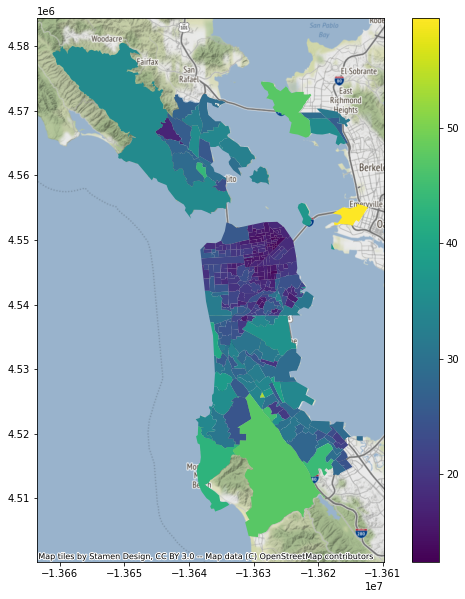

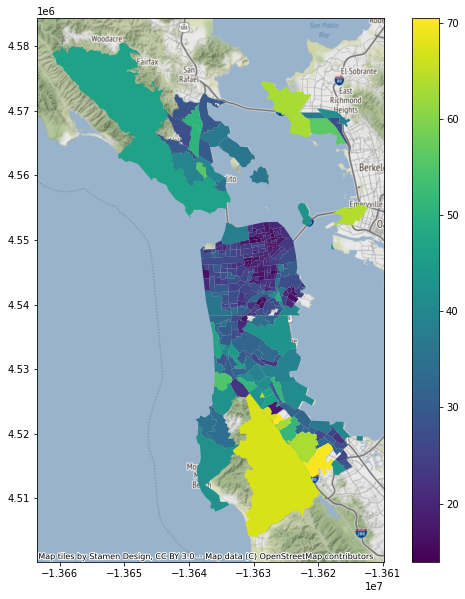

In [43]:
averages_pre_gps = tract_to_gps.merge(averages_pre_named.drop(columns = "geometry"), how = "right", on = "DISPLAY_NAME")
cx.add_basemap(averages_pre_gps.to_crs(3857).plot(figsize = (10, 10), column = "speed_mph_mean", legend = True))
averages_post_gps = tract_to_gps.merge(averages_post_named.drop(columns = "geometry"), how = "right", on = "DISPLAY_NAME")
cx.add_basemap(averages_post_gps.to_crs(3857).plot(figsize = (10, 10), column = "speed_mph_mean", legend = True))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

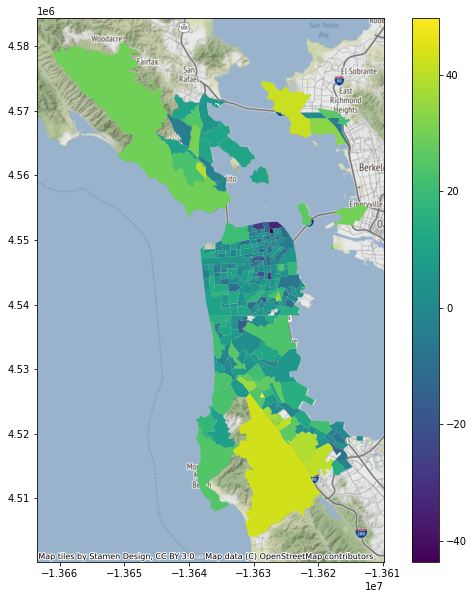

In [44]:
diff = averages_post_gps["speed_mph_mean"] - averages_pre_gps["speed_mph_mean"]
diff_pre_post = averages_post_gps.copy()
diff_pre_post["difference"] =  diff
diff_pre_post = diff_pre_post.dropna()
cx.add_basemap(diff_pre_post.to_crs(3857).plot(figsize = (10, 10), column = "difference", legend = True))

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [45]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

Origin Movement ID                            Origin Display Name  \
0                    1277  300 Hayes Street, Civic Center, San Francisco   
1                    1277  300 Hayes Street, Civic Center, San Francisco   
2                    1277  300 Hayes Street, Civic Center, San Francisco   
3                    1277  300 Hayes Street, Civic Center, San Francisco   
4                    1277  300 Hayes Street, Civic Center, San Francisco   
...                   ...                                            ...   
10333                1277  300 Hayes Street, Civic Center, San Francisco   
10334                1277  300 Hayes Street, Civic Center, San Francisco   
10335                1277  300 Hayes Street, Civic Center, San Francisco   
10336                1277  300 Hayes Street, Civic Center, San Francisco   
10337                1277  300 Hayes Street, Civic Center, San Francisco   

       Destination Movement ID  \
0                            9   
1                           20   
2                           21   
3                           44   
4                           46   
...                        ...   
10333                     2624   
10334                     2643   
10335                     2673   
10336                     2694   
10337                     2695   

                                Destination Display Name  \
0             500 Hyde Street, Tenderloin, San Francisco   
1       900 Sutter Street, Lower Nob Hill, San Francisco   
2      3400 Pierce Street, Marina District, San Franc...   
3             1700 Egbert Avenue, Bayview, San Francisco   
4              500 Chester Street, West Oakland, Oakland   
...                                                  ...   
10333      1300 16th Avenue, Inner Sunset, San Francisco   
10334         1300 Egbert Avenue, Bayview, San Francisco   
10335  100 Rutledge Street, Bernal Heights, San Franc...   
10336  1900 Buchanan Street, Western Addition, San Fr...   
10337  2200 Rivera Street, Sunset District, San Franc...   

                                            Date Range  \
0        3/1/2020 - 3/1/2020, Every day, Daily Average   
1        3/1/2020 - 3/1/2020, Every day, Daily Average   
2        3/1/2020 - 3/1/2020, Every day, Daily Average   
3        3/1/2020 - 3/1/2020, Every day, Daily Average   
4        3/1/2020 - 3/1/2020, Every day, Daily Average   
...                                                ...   
10333  3/31/2020 - 3/31/2020, Every day, Daily Average   
10334  3/31/2020 - 3/31/2020, Every day, Daily Average   
10335  3/31/2020 - 3/31/2020, Every day, Daily Average   
10336  3/31/2020 - 3/31/2020, Every day, Daily Average   
10337  3/31/2020 - 3/31/2020, Every day, Daily Average   

       Mean Travel Time (Seconds)  Range - Lower Bound Travel Time (Seconds)  \
0                             322                                        211   
1                             291                                        179   
2                             635                                        438   
3                             786                                        566   
4                             891                                        682   
...                           ...                                        ...   
10333                         502                                        411   
10334                         571                                        475   
10335                         367                                        265   
10336                         222                                        167   
10337                         917                                        778   

       Range - Upper Bound Travel Time (Seconds)  day  
0                                            489    1  
1                                            470    1  
2                                            920    1  
3                                           1090    1  
4                         

In [46]:
# Procedure 
# To answer the question "How the lockdown affected travel times", I created a line plot of the mean travel time for all the travels occurred in each day 
# and created a histogram and summary to compare the mean travel times of days between March 1st 2020 ~ March 14th 2020 and March 15th ~ March 31st 2020. 

# To answer the question which destinations were affected by lockdown, I grouped the data by Destination and found the mean travel time for time periods 
# between March 1st ~ 14th and March 15th ~ 31st. After computing the mean travel time for each destination, I found the difference in mean travel time between
# the two time periods. 
# * I found the dfference by (Pre-lockdown Time - Post Lockdown Tim since i assumed most travel times would decrease and it will be easier to work with postiive values)
# After finding the difference in seconds, I computed the percent change from the initial time period (!st~14th) since a 30 second change will have different 
# impact if the mean travel time was 200 seconds compared to 2000 seconds. After computing the percentage change, I divided the destinations in to 4 subgroubs 
# based on the magnitude and direction of change. 
# increase in travel time (% change < -5.0 %)
# minimal change in travel time (-5.0 % < % change < 5.0 %)
# decrease in travel time (5.0% < % change < 25.0 %)
# significant decrease in travel time (% change > 25.0 %)

# After dividing the destinations into subgroups based on their change in mean travel time, I plotted each destination using geo pandas and coordinates using the 
# tract_to_GPS GeoDataFrame to visualize the locations where the change in travel time is similar. 

# To answer the specific questions, I analyzed the locations based on the geopandas plot to see if there were any events or similarities in the destinations. 
# For locations with decreased mean travel time, I plotted the location into more specific subgroups based on which percentage change bin they fall into.
# For locations with increased mean travel time, I examined the data of rides headed towards San Rafael.
# I also computed the percentage change in mean travel time for rides headed towards specific cities (San Francisco, Oakland, Berkeley, etc) to examine the magnitude in change each location.
# Then, I computed the percentage change in mean travel time for districts within San Francisco to examine specific locations within the city. 

Text(0, 0.5, 'Mean Travel Time (Seconds)')

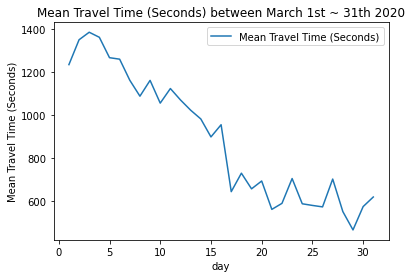

In [47]:
#Line plot of mean travel time by day
avg_travel_by_day = times_to_tract.groupby('day')["Mean Travel Time (Seconds)"].mean().reset_index()
avg_travel_by_day.plot.line(x= 'day', y= "Mean Travel Time (Seconds)")
plt.title("Mean Travel Time (Seconds) between March 1st ~ 31th 2020")
plt.ylabel("Mean Travel Time (Seconds)")

Mean Travel Time (Seconds)
count                 5795.000000
mean                  1202.281622
std                    671.200358
min                     51.000000
25%                    707.500000
50%                   1106.000000
75%                   1531.500000
max                   4144.000000

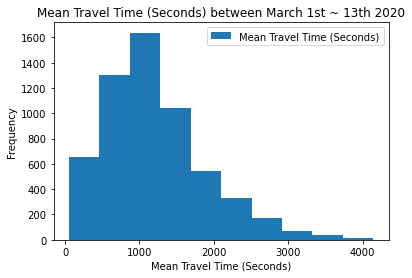

In [48]:
#Histogram/Summary of mean travel times pre lock-down
time_pre = times_to_tract[times_to_tract["day"] <= 13][["Mean Travel Time (Seconds)"]]
time_pre.plot.hist()
plt.xlabel("Mean Travel Time (Seconds)")
plt.title("Mean Travel Time (Seconds) between March 1st ~ 13th 2020")
time_pre.describe()

Mean Travel Time (Seconds)
count                 4543.000000
mean                   704.492846
std                    428.723296
min                     55.000000
25%                    390.000000
50%                    615.000000
75%                    919.500000
max                   2844.000000

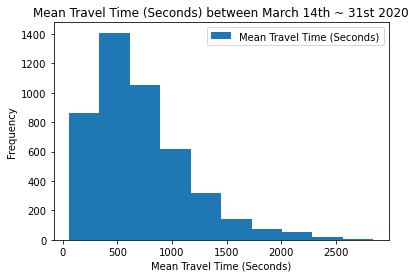

In [49]:
#Histogram/Summary of mean travel times post lock-down
time_post = times_to_tract[times_to_tract["day"] > 13][["Mean Travel Time (Seconds)"]]
time_post.plot.hist()
plt.xlabel("Mean Travel Time (Seconds)")
plt.title("Mean Travel Time (Seconds) between March 14th ~ 31st 2020")
time_post.describe()

Text(0.5, 1.0, 'Number of rides per day between March 1st ~ 31th 2020')

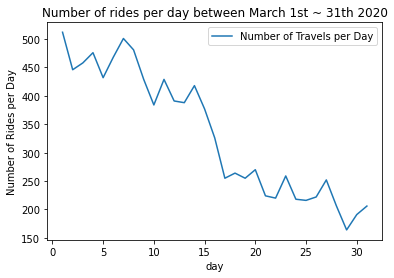

In [50]:
# Line plot of umber of rides per day 
avg_travel_by_day_count = times_to_tract.groupby('day')["Mean Travel Time (Seconds)"].count().reset_index().rename(columns = {"Mean Travel Time (Seconds)" : "Number of Travels per Day"})
avg_travel_by_day_count.plot.line(x= 'day', y = "Number of Travels per Day")
plt.ylabel("Number of Rides per Day")
plt.title("Number of rides per day between March 1st ~ 31th 2020")

In [51]:
#Conclusion 
# Overall mean travel time decreased after the lockdown along with the number of travels per day.
# Based on the line plot of the mean travel time from March 1st~31st, the mean travel time experiences a somewhat gradual decrease during the 1st to the 14th but a signficant drop around the 15th.
# Futhermore, comparing the results from the histogram and the summary statistics, the mean travel time after the 13th had a mean value lower around 500 seconds with the distribution shifted more towards 
# the left. From this, we can conclude that the mean travel time could have decreased due to the lock-down initiated on the 15th and the 16th.

# It is also notable to point out the decrease in number of the overall number of travels (rides) happening per day. After the lockdown, the number of rides almost halved in value which may be the reason 
# For decreased travel time since there are less traffic. 


In [52]:
#Creating a dataframe of the mean travel time by destination and dividing it into pre/post lockdown.
pre_lockdown_mean_time = times_to_tract[times_to_tract["day"] <= 13].groupby("Destination Display Name")["Mean Travel Time (Seconds)"].mean().reset_index()
post_lockdown_mean_time = times_to_tract[times_to_tract["day"] > 13].groupby("Destination Display Name")["Mean Travel Time (Seconds)"].mean().reset_index()
merged_pre_post = pre_lockdown_mean_time.merge(post_lockdown_mean_time, how = "inner", on = "Destination Display Name").rename(columns = {"Mean Travel Time (Seconds)_x" : "Mean Travel Time (Seconds) Pre", "Mean Travel Time (Seconds)_y" : "Mean Travel Time (Seconds) Post"})
merged_pre_post.head()

Destination Display Name  \
0   0 Avoca Alley, West of Twin Peaks, San Francisco   
1               0 Bass Court, Bayview, San Francisco   
2     0 Berkeley Way, Diamond Heights, San Francisco   
3          0 Bernard Street, Nob Hill, San Francisco   
4  0 Brookdale Avenue, Visitacion Valley, San Fra...   

   Mean Travel Time (Seconds) Pre  Mean Travel Time (Seconds) Post  
0                     1016.230769                       847.500000  
1                      999.923077                       699.571429  
2                      948.769231                       788.666667  
3                      507.000000                       367.888889  
4                     1096.000000                       781.000000

In [53]:
#Calculating the difference in travel time and computing the percent change.
merged_pre_post["difference"] = merged_pre_post["Mean Travel Time (Seconds) Pre"] - merged_pre_post["Mean Travel Time (Seconds) Post"]
merged_pre_post["% Change"] = merged_pre_post["difference"]/merged_pre_post["Mean Travel Time (Seconds) Pre"] * 100
merged_pre_post.head()

Destination Display Name  \
0   0 Avoca Alley, West of Twin Peaks, San Francisco   
1               0 Bass Court, Bayview, San Francisco   
2     0 Berkeley Way, Diamond Heights, San Francisco   
3          0 Bernard Street, Nob Hill, San Francisco   
4  0 Brookdale Avenue, Visitacion Valley, San Fra...   

   Mean Travel Time (Seconds) Pre  Mean Travel Time (Seconds) Post  \
0                     1016.230769                       847.500000   
1                      999.923077                       699.571429   
2                      948.769231                       788.666667   
3                      507.000000                       367.888889   
4                     1096.000000                       781.000000   

   difference   % Change  
0  168.730769  16.603588  
1  300.351648  30.037475  
2  160.102564  16.874764  
3  139.111111  27.438089  
4  315.000000  28.740876

In [54]:
#Commputing quantile for significant decrease. 
percentage_change_for_time_decrease = merged_pre_post[merged_pre_post["% Change"] > 0][["% Change"]]
percentage_change_for_time_decrease.quantile(0.9)

% Change    27.569706
Name: 0.9, dtype: float64

In [55]:
#Dividing into 4 subgroups based on percentage change.
increased_time = merged_pre_post[merged_pre_post["% Change"] < -5]
sig_decreased_time = merged_pre_post[merged_pre_post["% Change"] > 27.5]
decreased_time = merged_pre_post[(merged_pre_post["% Change"] > 5) & (merged_pre_post["% Change"] <  27.5)]
minimal_change = merged_pre_post[np.abs(merged_pre_post["% Change"]) < 5 ]
decreased_time.head()


Destination Display Name  \
0  0 Avoca Alley, West of Twin Peaks, San Francisco   
2    0 Berkeley Way, Diamond Heights, San Francisco   
3         0 Bernard Street, Nob Hill, San Francisco   
5            0 Brookhaven Court, Fairmont, Pacifica   
6                        0 Burgess Court, Sausalito   

   Mean Travel Time (Seconds) Pre  Mean Travel Time (Seconds) Post  \
0                     1016.230769                       847.500000   
2                      948.769231                       788.666667   
3                      507.000000                       367.888889   
5                     1101.615385                       962.000000   
6                     1146.692308                       982.181818   

   difference   % Change  
0  168.730769  16.603588  
2  160.102564  16.874764  
3  139.111111  27.438089  
5  139.615385  12.673696  
6  164.510490  14.346524

In [56]:

#Merging dataframe to create GeoDataFrame to plot geopandas map
unique_tracts = times_to_tract.groupby("Destination Display Name")["Mean Travel Time (Seconds)"].mean().reset_index()
times_to_tract_with_gps = tract_to_gps.merge(unique_tracts, how = "right", left_on = "DISPLAY_NAME", right_on = "Destination Display Name")
minimal_change_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(minimal_change["Destination Display Name"])]
increased_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(increased_time["Destination Display Name"])]
sig_decreased_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(sig_decreased_time["Destination Display Name"])]
decreased_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(decreased_time["Destination Display Name"])]
start_location = tract_to_gps[tract_to_gps["MOVEMENT_ID"] == 1277]

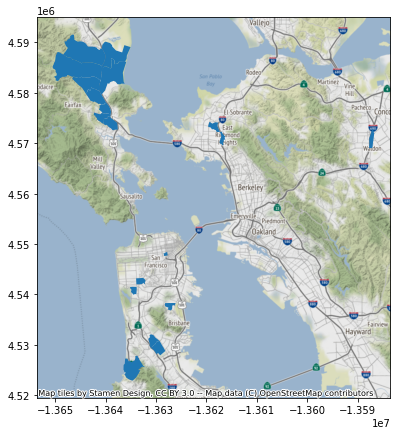

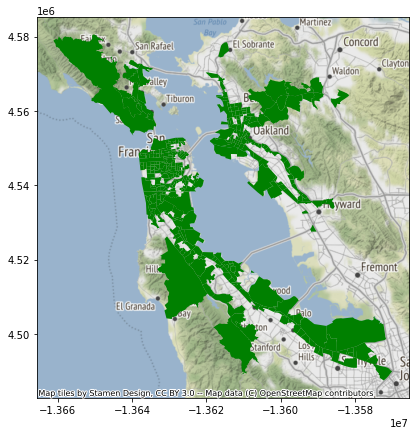

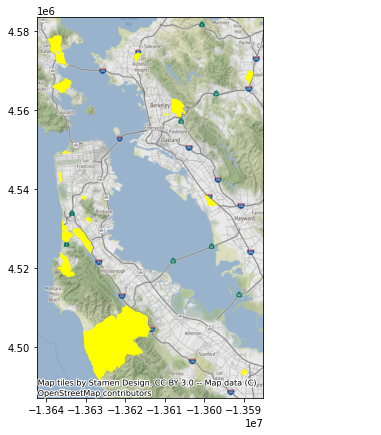

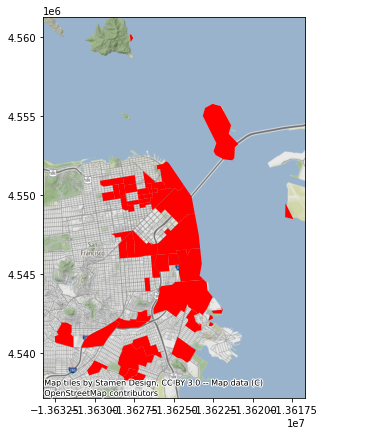

In [57]:
#plotting each subgroup
cx.add_basemap(increased_location.to_crs(3857).plot(figsize=(7, 7)))
cx.add_basemap(decreased_location.to_crs(3857).plot(figsize=(7, 7), color = "green"))
cx.add_basemap(minimal_change_location.to_crs(3857).plot(figsize=(7, 7), color = "yellow"))
cx.add_basemap(sig_decreased_location.to_crs(3857).plot(figsize=(7, 7), color = "red"))

In [58]:
# For most cases, the mean travel time decreased which is consistent with the result extracted from the previous part. 

# Areas that experienced significant decrease in travel time was located within the city of San Francisco near the North east, Central East, and South East Region.
# This may be due to the fact that this region is highly urban location containing the financial district, Downtown San Francisco, Nob Hill, Mission Street, and Marekt Street.

# A lot of the destinations where the travel time increased was located near San Rafael. 

# A large sum of the location that experienced no change in travel time was located near the state parks which is a rural area with low traffic prior to the lockdown as well. 

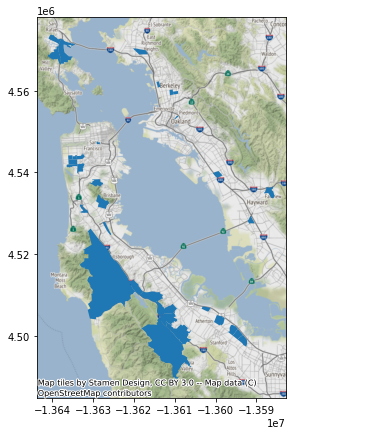

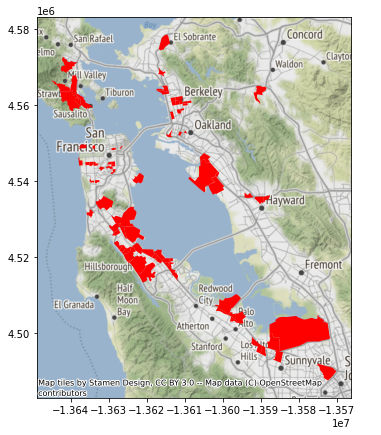

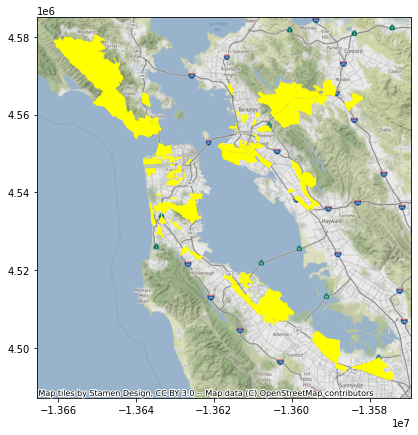

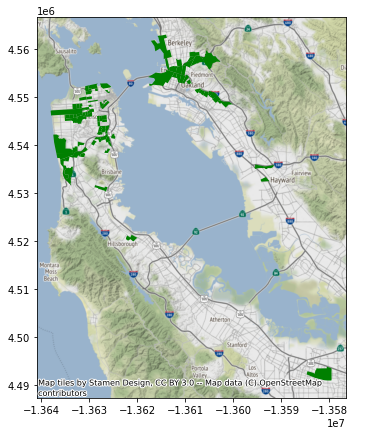

In [59]:
# Subgroups for decreased time
five_to_ten = decreased_time[(decreased_time["% Change"] > 5) & (decreased_time["% Change"] <  10)]
ten_to_fifthteen = decreased_time[(decreased_time["% Change"] >= 10) & (decreased_time["% Change"] <  15)]
fifthteen_to_twenty = decreased_time[(decreased_time["% Change"] >= 15) & (decreased_time["% Change"] <  20)]
twenty_to_tenwtyfive = decreased_time[(decreased_time["% Change"] >= 20) & (decreased_time["% Change"] <  25)]
# Locations 
five_to_ten_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(five_to_ten["Destination Display Name"])]
ten_to_fifthteen_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(ten_to_fifthteen["Destination Display Name"])]
fifthteen_to_twenty_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(fifthteen_to_twenty["Destination Display Name"])]
twenty_to_tenwtyfive_location = times_to_tract_with_gps[times_to_tract_with_gps["DISPLAY_NAME"].isin(twenty_to_tenwtyfive["Destination Display Name"])]
# plot
cx.add_basemap(five_to_ten_location.to_crs(3857).plot(figsize=(7, 7)))
cx.add_basemap(ten_to_fifthteen_location.to_crs(3857).plot(figsize=(7, 7), color = "red"))
cx.add_basemap(fifthteen_to_twenty_location.to_crs(3857).plot(figsize=(7, 7), color = "yellow"))
cx.add_basemap(twenty_to_tenwtyfive_location.to_crs(3857).plot(figsize=(7, 7), color = "green"))

In [60]:
# Based on the mean travel time % change falling into different percentage groups, it seems like the areas that are closer to the starting point expereinced 
# larger percentage changes excluding certain outliers. 

<AxesSubplot:xlabel='day'>

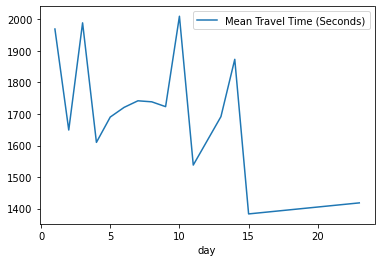

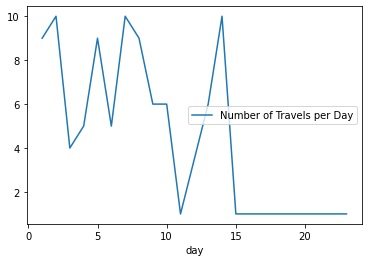

In [61]:
# Mean travel time and number of travels per day for destinations located in San Rafael 
to_san_rafael_time = times_to_tract[times_to_tract["Destination Display Name"].str.contains("San Rafael")].groupby('day')["Mean Travel Time (Seconds)"].mean().reset_index()
to_san_rafael_time.plot.line("day", "Mean Travel Time (Seconds)")
to_san_rafael_count = times_to_tract[times_to_tract["Destination Display Name"].str.contains("San Rafael")].groupby('day')["Mean Travel Time (Seconds)"].count().reset_index().rename(columns = {"Mean Travel Time (Seconds)" : "Number of Travels per Day"})
to_san_rafael_count.plot.line("day", "Number of Travels per Day")

In [62]:
#Extracting unique cities for ride destination (more than 8 destinations)
merged_pre_post_by_city = merged_pre_post.copy()
merged_pre_post_by_city["Destination City"] = merged_pre_post["Destination Display Name"].str.split(",", expand = True)[2]
merged_pre_post_by_city_counts = merged_pre_post_by_city.groupby("Destination City")["% Change"].size().reset_index()
valid_cities = merged_pre_post_by_city_counts[merged_pre_post_by_city_counts["% Change"] >= 8]["Destination City"]
merged_pre_post_by_valid_city = merged_pre_post_by_city[merged_pre_post_by_city["Destination City"].isin(valid_cities)]
percent_change_by_city = merged_pre_post_by_valid_city.groupby("Destination City")["% Change"].mean().reset_index()
percent_change_by_city

Destination City   % Change
0              Berkeley  12.118427
1             Daly City  14.588089
2               Oakland  18.774065
3         San Francisco  21.755848
4           San Leandro  13.502051
5             San Mateo  15.085832
6   South San Francisco   4.100346

In [63]:
#Extracting unique location within San Francisco for ride destination (more than 5 destinations)
merged_pre_post_by_SF = merged_pre_post_by_city[merged_pre_post_by_city["Destination City"] == " San Francisco"]
merged_pre_post_by_SF_loc = merged_pre_post_by_SF.copy()
merged_pre_post_by_SF_loc["Sub City Headed"] = merged_pre_post_by_SF["Destination Display Name"].str.split(", ", expand = True)[1]
merged_pre_post_by_SF_loc_counts = merged_pre_post_by_SF_loc.groupby("Sub City Headed")["% Change"].size().reset_index()
valid_sub_cities = merged_pre_post_by_SF_loc_counts[merged_pre_post_by_SF_loc_counts["% Change"] >= 5]["Sub City Headed"]
merged_pre_post_by_SF_loc_valid_sub_city = merged_pre_post_by_SF_loc[merged_pre_post_by_SF_loc["Sub City Headed"].isin(valid_sub_cities)]
percent_change_by_sub_city = merged_pre_post_by_SF_loc_valid_sub_city.groupby("Sub City Headed")["% Change"].mean().reset_index()
percent_change_by_sub_city.sort_values("% Change")

Sub City Headed   % Change
13  West of Twin Peaks  12.013866
6           Noe Valley  13.723748
10     Sunset District  13.726746
8    Richmond District  18.600789
3         Inner Sunset  19.322903
14    Western Addition  21.884323
11          Tenderloin  23.153574
4      Marina District  23.410495
5     Mission District  23.628293
0              Bayview  24.671752
1       Bernal Heights  25.071519
2            Excelsior  25.411972
9      South of Market  25.475818
12   Visitacion Valley  25.839099
7      Pacific Heights  28.371557

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [64]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    return df.pivot_table(values = 'speed_mph_mean', index = 'MOVEMENT_ID', columns = 'day', aggfunc = np.mean)
    
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [65]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [66]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    X_train = df.iloc[:, :T].to_numpy()
    for i in range(1, (len(df.columns)-n_val-T), 1):
        X_t = df.iloc[:, 0 + i:T + i].to_numpy()
        X_train = np.concatenate((X_train, X_t))
    Y_train = df.iloc[:, T].to_numpy()
    for i in range(1, (len(df.columns)-n_val-T), 1):
        Y_t = df.iloc[:, T + i].to_numpy()
        Y_train = np.concatenate((Y_train, Y_t))
    X_val = df.iloc[:, len(df.columns)-n_val-T:-n_val].to_numpy()
    for i in range(1, n_val, 1):
        X_v = df.iloc[:, len(df.columns)-n_val-T + i : -n_val + i].to_numpy()
        X_val = np.concatenate((X_val, X_v))
    Y_val = df.iloc[:, -n_val].to_numpy()
    for i in range(1, n_val, 1):
        Y_v = df.iloc[:, -n_val + i].to_numpy()
        Y_val = np.concatenate((Y_val, Y_v))
    return X_train, Y_train, X_val, Y_val

def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    X_del = []
    Y_del = []
    for i in range(len(X)):
        if((np.isnan(X[i]).any() == True) | (np.isnan(y[i]).any() == True)):
            X_del = np.append(X_del, i).astype(int)
            Y_del = np.append(Y_del, i).astype(int)
    X = np.delete(X, X_del, 0)
    y = np.delete(y, Y_del, 0)
    return (X, y)
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [67]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [68]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    X_train, y_train, X_val, y_val = time_series_to_numpy(time_series, T, n_val)
    train = remove_nans(X_train, y_train)
    val = remove_nans(X_val, y_val)
    return train[0], train[1], val[0], val[1]
    
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)
X_train.shape

(1705, 5)

In [69]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [70]:
time_series

day                 1          2          3          4          5          6   \
MOVEMENT_ID                                                                     
9            16.196918  14.395121  13.868696  14.225414  14.312199  13.811991   
20           17.418045  15.460956  15.463297  15.419764  15.291956  15.227310   
21           15.141171  13.176998  13.781490  14.052113  14.078134  13.636357   
44           25.079544  23.492586  22.727711  22.274143  21.874703  23.082414   
78           16.174464  16.755496  16.039120  16.118401  15.665069  15.797723   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN  18.600000  17.787000   
2694         17.809761  16.725889  16.530783  16.446517  16.503053  16.652473   
2695         20.106061  20.228850  19.849135  20.145877  22.357605  19.250479   
2700         34.586890  31.372308  30.866382  31.000998  31.636377  30.213992   
2708         25.176235  24.725863  24.130040  24.287102  24.364056  25.090063   

day                 7          8          9          10  ...         22  \
MOVEMENT_ID                                              ...              
9            15.508637  16.210738  14.845320  14.711534  ...  15.880078   
20           17.088325  18.088862  16.178105  15.295494  ...  18.843376   
21           13.958269  14.642295  15.616215  14.850471  ...        NaN   
44           22.875819  25.653848  23.501387  22.739869  ...  24.381933   
78           15.302616  19.284080  16.253357  16.131290  ...        NaN   
...                ...        ...        ...        ...  ...        ...   
2691         23.473000        NaN  19.038000        NaN  ...        NaN   
2694         17.427329  18.057287  17.310272  16.998730  ...  23.886576   
2695         19.223717  19.471282  20.497077  20.401085  ...  29.218800   
2700         33.581884  35.443617  32.179867  32.951855  ...  47.265544   
2708         25.552157  26.296112  25.512403  24.886063  ...        NaN   

day                 23         24         25         26         27         28  \
MOVEMENT_ID                                                                     
9            17.019573  15.527393  15.925605  15.959744  17.317841  17.845053   
20           17.029943  16.286795  17.007889  15.205696  17.461643  16.997424   
21                 NaN        NaN        NaN        NaN        NaN        NaN   
44           25.350188  31.126033        NaN  22.518500  27.697570  26.899667   
78                 NaN  15.690000        NaN        NaN  16.849000        NaN   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN        NaN        NaN   
2694         23.410192  23.302396  23.031966  23.107702  23.581885  24.382866   
2695               NaN        NaN        NaN  23.396500        NaN  19.708000   
2700         39.722920  42.812205  39.087122  54.935270  40.893501  45.208787   
2708         19.323625  27.792333  25.255979  25.388000  24.786000  27.643333   

day                 29         30         31  
MOVEMENT_ID                                   
9            17.839214  15.743376  15.797248  
20           19.024721  14.134949  17.287814  
21                 NaN        NaN        NaN  
44           19.777429  24.385409  24.683422  
78                 NaN  16.493000  16.767400  
...                ...        ...        ...  
2691               NaN        NaN        NaN  
2694         23.278001  23.426889  24.056357  
2695         26.461900        NaN  19.959500  
2700         60.177978  38.714434  48.398038  
2708         27.497250  29.508200        NaN  

[295 rows x 31 columns]

In [71]:
time_series_pre

day                 1          2          3          4          5          6   \
MOVEMENT_ID                                                                     
9            16.196918  14.395121  13.868696  14.225414  14.312199  13.811991   
20           17.418045  15.460956  15.463297  15.419764  15.291956  15.227310   
21           15.141171  13.176998  13.781490  14.052113  14.078134  13.636357   
44           25.079544  23.492586  22.727711  22.274143  21.874703  23.082414   
78           16.174464  16.755496  16.039120  16.118401  15.665069  15.797723   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN  18.600000  17.787000   
2694         17.809761  16.725889  16.530783  16.446517  16.503053  16.652473   
2695         20.106061  20.228850  19.849135  20.145877  22.357605  19.250479   
2700         34.586890  31.372308  30.866382  31.000998  31.636377  30.213992   
2708         25.176235  24.725863  24.130040  24.287102  24.364056  25.090063   

day                 7          8          9          10         11         12  \
MOVEMENT_ID                                                                     
9            15.508637  16.210738  14.845320  14.711534  13.739901  14.391436   
20           17.088325  18.088862  16.178105  15.295494  14.637109  14.282602   
21           13.958269  14.642295  15.616215  14.850471  13.790100  14.573349   
44           22.875819  25.653848  23.501387  22.739869  23.756560  24.989269   
78           15.302616  19.284080  16.253357  16.131290  15.773117  16.091415   
...                ...        ...        ...        ...        ...        ...   
2691         23.473000        NaN  19.038000        NaN        NaN  22.107000   
2694         17.427329  18.057287  17.310272  16.998730  16.891788  17.008323   
2695         19.223717  19.471282  20.497077  20.401085  23.870537  20.215396   
2700         33.581884  35.443617  32.179867  32.951855  31.574525  32.172958   
2708         25.552157  26.296112  25.512403  24.886063  23.902599  25.262721   

day                 13  
MOVEMENT_ID             
9            13.955833  
20           14.437358  
21           15.177251  
44           23.176275  
78           16.208158  
...                ...  
2691               NaN  
2694         17.559142  
2695         20.343131  
2700         31.334364  
2708         24.450025  

[295 rows x 13 columns]

In [72]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

Text(0, 0.5, 'Actual')

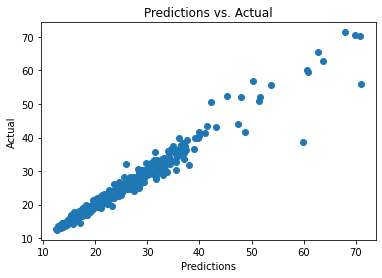

In [73]:
reg = LinearRegression().fit(X_train, y_train) # set to trained linear model
score = reg.score(X_val, y_val) # report r^2 score
# create the scatter plot below
plt.scatter(reg.predict(X_val), y_val)
plt.title("Predictions vs. Actual")
plt.xlabel("Predictions")
plt.ylabel("Actual")

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [74]:
score

0.963923292212207

In [75]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [76]:
time_series_x_pre = time_series.iloc[:, 8:13] # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = time_series[[14]] # get 'time series' dataframe for 14th
ans = remove_nans(time_series_x_pre.to_numpy(), time_series_y_post.to_numpy())
score_pre_14th = reg.score(ans[0], ans[1])
score_pre_14th

0.9337122097376676

In [77]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

In [78]:
time_series_x_pre

day                 9          10         11         12         13
MOVEMENT_ID                                                       
9            14.845320  14.711534  13.739901  14.391436  13.955833
20           16.178105  15.295494  14.637109  14.282602  14.437358
21           15.616215  14.850471  13.790100  14.573349  15.177251
44           23.501387  22.739869  23.756560  24.989269  23.176275
78           16.253357  16.131290  15.773117  16.091415  16.208158
...                ...        ...        ...        ...        ...
2691         19.038000        NaN        NaN  22.107000        NaN
2694         17.310272  16.998730  16.891788  17.008323  17.559142
2695         20.497077  20.401085  23.870537  20.215396  20.343131
2700         32.179867  32.951855  31.574525  32.172958  31.334364
2708         25.512403  24.886063  23.902599  25.262721  24.450025

[295 rows x 5 columns]

In [79]:
time_series_y_post

day                 14
MOVEMENT_ID           
9            15.878056
20           16.095385
21           15.172252
44           25.006452
78           15.128800
...                ...
2691         17.917000
2694         17.714930
2695         20.321418
2700         33.941697
2708         29.023549

[295 rows x 1 columns]

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

Text(0, 0.5, 'Actual')

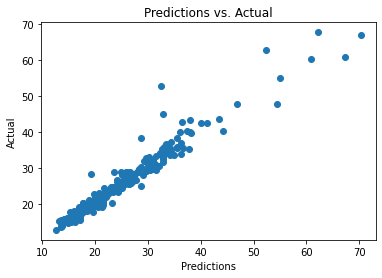

In [80]:
plt.scatter(reg.predict(ans[0]), ans[1])
plt.title("Predictions vs. Actual")
plt.xlabel("Predictions")
plt.ylabel("Actual")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



The lowest point on the line plot is day 17th. The worsening begins on the 15th because it is the day the lockdown is initiated and the average travel speed becomes affected by it which means that one cannot accurately predict the mean travel time with the previous data from pre-lockdown. The 17th has the worst performance since it is the day shelter in place for 6 counties take effect. The dip on the 9th is foreshadowed by our EDA since there was a sudden increase in average travel speed on the 9th when we look at question 2.a.iv. This was the day after covid entered the bay area with the crusie ship with infected passengers and it would have decreased the daily traffic on the 9th. The model miraculously recovers since it uses the past 5 days to predict the travel speed. This indiciates that the model will utilize the post lockdown average speed to predict the average speed which will lead to higher accuracy. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

<AxesSubplot:xlabel='days'>

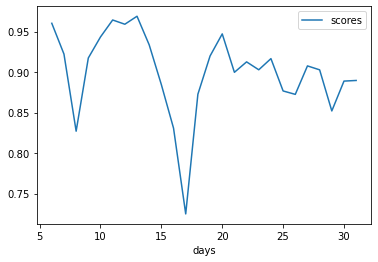

In [81]:
scores = []
for i in range(6, len(time_series.columns)+1):
    pre_five = time_series.iloc[:, i-6:i-1]
    d_day = time_series[[i]]
    answ = remove_nans(pre_five.to_numpy(), d_day.to_numpy())
    score_to_add = reg.score(answ[0], answ[1])
    scores = np.append(scores, score_to_add)
days = np.arange(6, len(time_series.columns)+1)
df = pd.DataFrame({'days' : days,'scores' : scores})
df.plot.line(x= 'days', y = 'scores')
#add labels to plot

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

Text(0, 0.5, 'Actual')

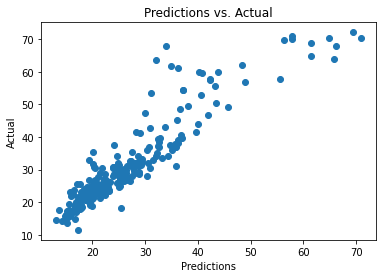

In [82]:
time_series_x_pre_seventeen = time_series.iloc[:, 11:16] 
time_series_y_seventeen = time_series[[17]] 
ans_two = remove_nans(time_series_x_pre_seventeen.to_numpy(), time_series_y_seventeen.to_numpy())
plt.scatter(reg.predict(ans_two[0]), ans_two[1])
plt.title("Predictions vs. Actual")
plt.xlabel("Predictions")
plt.ylabel("Actual")

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

The delta is so much more effective on the 17th because the 17th was predicted by the previous 5 days which includes low pre lockdwn (12~14) travel times and high post lockdown (15~16) travel times. The delta is so effective for the 17th since it reduces the affect of the difference in pre/post lockdown speeds by subracting the daily averages and applying normalization to the data.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [83]:
time_series_delta = time_series_pre -  speeds_daily[0:13]  # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day                 1         2         3         4         5         6   \
MOVEMENT_ID                                                                
9            -7.436210 -7.929735 -7.957726 -7.706332 -7.673488 -8.288859   
20           -6.215082 -6.863900 -6.363125 -6.511982 -6.693731 -6.873540   
21           -8.491956 -9.147858 -8.044932 -7.879632 -7.907553 -8.464493   
44            1.446417  1.167730  0.901289  0.342397 -0.110985  0.981564   
78           -7.458664 -5.569360 -5.787301 -5.813345 -6.320619 -6.303126   
...                ...       ...       ...       ...       ...       ...   
2691               NaN       NaN       NaN       NaN -3.385687 -4.313850   
2694         -5.823366 -5.598968 -5.295639 -5.485229 -5.482634 -5.448377   
2695         -3.527067 -2.096006 -1.977287 -1.785869  0.371917 -2.850371   
2700         10.953762  9.047451  9.039961  9.069252  9.650690  8.113142   
2708          1.543108  2.401007  2.303618  2.355356  2.378369  2.989213   

day                 7          8         9          10        11        12  \
MOVEMENT_ID                                                                  
9            -7.342673  -7.838718 -8.163539  -7.950124 -9.037052 -8.687048   
20           -5.762984  -5.960594 -6.830754  -7.366163 -8.139844 -8.795882   
21           -8.893040  -9.407162 -7.392644  -7.811186 -8.986853 -8.505135   
44            0.024509   1.604391  0.492527   0.078211  0.979607  1.910786   
78           -7.548693  -4.765377 -6.755502  -6.530367 -7.003837 -6.987069   
...                ...        ...       ...        ...       ...       ...   
2691          0.621691        NaN -3.970859        NaN       NaN -0.971484   
2694         -5.423980  -5.992169 -5.698587  -5.662927 -5.885166 -6.070161   
2695         -3.627592  -4.578175 -2.511783  -2.260573  1.093583 -2.863087   
2700         10.730575  11.394160  9.171008  10.290198  8.797572  9.094474   
2708          2.700848   2.246655  2.503544   2.224406  1.125645  2.184237   

day                13  
MOVEMENT_ID            
9           -9.364599  
20          -8.883074  
21          -8.143181  
44          -0.144157  
78          -7.112274  
...               ...  
2691              NaN  
2694        -5.761289  
2695        -2.977301  
2700         8.013932  
2708         1.129593  

[295 rows x 13 columns]

In [84]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [85]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)
reg_delta = LinearRegression().fit(X_delta_train, y_delta_train)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [86]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [87]:
time_series_delta_all = time_series - speeds_daily
time_series_x_pre_seventeen_delta = time_series_delta_all.iloc[:, 11:16] 
time_series_y_seventeen_delta = time_series_delta_all[[17]] 
ans_three = remove_nans(time_series_x_pre_seventeen_delta.to_numpy(), time_series_y_seventeen_delta.to_numpy())
res_4ci4 = reg_delta.score(ans_three[0], ans_three[1])
res_4ci4
# 83% is the correct value

0.8346539614612526

In [88]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [89]:
#removed
res_4ci5 = ...

In [90]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ci5 0[0]>", line 1, in <module>
                np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
              File "<__array_function__ internals>", line 5, in isclose
              File "/opt/conda/lib/python3.9/site-packages/numpy/core/numeric.py", line 2355, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [91]:
time_series_post = time_series.iloc[:, 13:]
X_train_post, y_train_post, X_val_post, y_val_post = time_series_to_dataset(time_series_post, 5, 0)

score_og_post = reg.score(X_train_post, y_train_post)

score_og_post

0.9014738674628209

In [92]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [93]:
X_train_post_two, y_train_post_two, X_val_post_two, y_val_post_two = time_series_to_dataset(time_series_post, 5, 2)
reg_post_two = LinearRegression().fit(X_train_post_two, y_train_post_two)
score_post = reg_post_two.score(X_val_post_two, y_val_post_two)
score_post

0.8993687576351703

In [94]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [95]:
X_t, y_t, X_v, y_v = time_series_to_dataset(time_series, 5, 5)
reg_all = LinearRegression().fit(X_t, y_t)
res_4civ = reg_all.score(X_v, y_v)
res_4civ

0.8843433608623491

In [96]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

**Problem: Our model will address that the destination of the uber ride does play a crucial factor in the mean travel time which would signify that the travel time of the pricing algorithm should be valued differently based on the route and destination they are headed.**

**Hypothesis: The RMSE will be significantly lower for linear regression models predicting the post lockdown mean travel time that has a higher emphasis on categorical variables such as city boundaries, county boundaries, crossing over a bridge, highly populated area compared to a linear regression model that soley focuses on the quantitative variables such as mean travel time.** (Similar R^2)

**Experiment 1: Linear Regression Model to predict travel time from 300 Hayes Street, Civic Center, SF to Any location within the city of Berkeley.** 

First model will use the mean_travel_time from the times_to_tract dataframe to predict the travel time of rides headed to berkeley post lockdown. 

Second model will be based on a combined model with multiple regressors but will put less emphasis on the quantitative variable of the travel times with a mean value for the entire pre-lockdown duration for each destination.**

**Experiment 2: Linear Regression Model to predict travel time from 300 Hayes Street, Civic Center, SF to Bayview, SF.** 
Overall approach is the same as Experiment 1 but both models will train on destinations that are headed to somewhere in SF

There will be three types of baseline models. 
The first two will be linear regression models with the purpose of predicting the average travel time of uber rides post lockdown from 300 Hayes Street, Civic Center, SF to Berkeley and to Bay View.

The first model will have a similar approach to the guided EDA where I split the data based on the aggregated travel time for each day for all MOVEMENT IDs (Destinations). It will only involve qunatitative variables to predict the travel time 

The second model will have a different approach where we split the times_to_tract data table into pre-lockdown (13th) and post-lockdown (14th~31st) data. Then I will create a new dataframe with data from pre-lockdown to predict the average post lock down travel time headed towards Berkeley and Bay view. The key difference from the first model is that the second model emphasizes the usage of qualititave variables such as the name of they city headed, as well as the subcity headed. 


In [97]:
PATH_TRACT_DATA = 'data/census2000_tracts_nowater.csv'
tract_data = pd.read_csv(PATH_TRACT_DATA)
tract_data.head()

the_geom  OBJECTID  FIPSSTCO  \
0  MULTIPOLYGON (((-122.41134870232011 37.7106046...       200      6075   
1  MULTIPOLYGON (((-122.43781181316648 37.7119199...       201      6075   
2  MULTIPOLYGON (((-122.41573210323257 37.7125135...       202      6075   
3  MULTIPOLYGON (((-122.40245957172256 37.7121793...       203      6075   
4  MULTIPOLYGON (((-122.40618954106145 37.7152443...       204      6075   

   TRT2000       STFID  TRACTID  STATE  COUNTY  TRACT  POP2000  ...  \
0    26404  6075026404   264.04      6      75  26404     2287  ...   
1    26303  6075026303   263.03      6      75  26303     4529  ...   
2    60502  6075060502   605.02      6      75  60502     3416  ...   
3    26403  6075026403   264.03      6      75  26403     4112  ...   
4    26401  6075026401   264.01      6      75  26401     3733  ...   

   MHH_CHILD  FHH_CHILD  FAMILIES  AVE_FAM_SZ  HSE_UNITS  URBAN  RURAL  \
0         11         67       446        4.48        521      0      0   
1         19         53       958        3.99       1217      0      0   
2         34        376       841        3.66       1009      0      0   
3         22         48       834        4.27       1020      0      0   
4         12         41       760        4.35        911      0      0   

   VACANT  OWNER_OCC  RENTER_OCC  
0      14        340         167  
1      32        798         387  
2      26        193         790  
3      17        623         380  
4      20        670         221  

[5 rows x 47 columns]

In [98]:
HOOD_TRACT_DATA = 'data/Analysis_Neighborhoods.csv'
hood_tract_data = pd.read_csv(HOOD_TRACT_DATA)
hood_tract_data.head()

the_geom       GEOID  \
0  MULTIPOLYGON (((-122.43246699970955 37.7737570...  6075016400   
1  MULTIPOLYGON (((-122.4235409996432 37.77967400...  6075016100   
2  MULTIPOLYGON (((-122.42468700019211 37.7853350...  6075015900   
3  MULTIPOLYGON (((-122.42468700019211 37.7853350...  6075015500   
4  MULTIPOLYGON (((-122.43491799981281 37.7858759...  6075015300   

              NHOOD  TRACTCE10    SHAPE_AREA     SHAPE_LEN  
0      Hayes Valley      16400  3.326589e+06   7589.679396  
1  Western Addition      16100  3.970259e+06   8525.808755  
2  Western Addition      15900  3.179072e+06   8000.966619  
3         Japantown      15500  3.364565e+06  12144.016761  
4   Pacific Heights      15300  2.515363e+06   6918.268026

In [99]:
TRAFFIC_VOLUME_DATA = 'data/Traffic_Volumes_AADT.csv'
traffic_volume_data = pd.read_csv(TRAFFIC_VOLUME_DATA)
traffic_volume_data.head()

OBJECTID  District Route County Postmile        Descriptn  Back_p_h  \
0         1        11    11     SD       0R  BEG RIGHT ALIGN         0   
1         2        11    11     SD   0.137L   BEG LEFT ALIGN         0   
2         3        11    11     SD   0.481R  END RIGHT ALIGN       360   
3         4        11    11     SD   0.481L   END LEFT ALIGN       340   
4         5        11    11     SD    0.745        SANYO AVE       700   

   Back_pk_m  Back_AADT  Ahead_pk_h  Ahead_pk_m  Ahead_AADT  Lat_S_or_W  \
0          0          0         360        3750        3400    0.000000   
1          0          0        6000       73000        3100   32.564405   
2       3750       3400           0           0           0    0.000000   
3       3400       3100           0           0           0   32.564151   
4       7150       6500         780        7800        7100   32.564054   

   Lon_S_or_W  Lat_N_or_E  Lon_N_or_E  
0    0.000000   32.563906 -116.954639  
1 -116.951920    0.000000    0.000000  
2    0.000000   32.564051 -116.945546  
3 -116.945395    0.000000    0.000000  
4 -116.940943   32.563923 -116.940964

In [100]:
#THE_HOOD_DATA = 'data/SFFind_Neighborhoods.csv'
#hood_data = pd.read_csv(THE_HOOD_DATA)
#hood_data.head()

**Importing**

In [101]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV

**Helper Functions**

In [102]:
def remove_uncomparable_dest(tr, te, name):
    tr = tr[tr[name].isin(te[name])]
    te = te[te[name].isin(tr[name])]
    return tr, te

def rmse(X, y):
    return np.sqrt(np.mean((y - X)**2))

def train_model_with_phi(df, phi, X, Y):
    model = LinearRegression()
    Phi = phi(X)
    model.fit(Phi, Y)
    yhat = model.predict(Phi)
    return model, yhat

def please_give_jaemin_zero(actual, predicted):
    residual = actual - predicted
    fig = go.Figure()
    data_scatter = go.Scatter(x = predicted, y = residual,
                             mode = 'markers',
                             marker = dict(color = 'red', size = 8), name = 'residuals vs. fitted values')
    fig.add_trace(data_scatter)
    fig.add_trace(go.Scatter(x = [0, 35], y = [0, 0], name = 'residuals = 0', marker = dict(color = 'black')))
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), 
                      height=400,
                     xaxis_title=r"Fitted Values",
                     yaxis_title="Residuals")

    return fig

def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

def compare_models(models):
    # Compute the training error for each model
    training_rmse = [rmse_score(model, tr, tr['Post Lock Down Mean Travel Time']) for model in models.values()]
    # Compute the cross validation error for each model
    #validation_rmse = [np.mean(cross_val_score(model, tr, tr['Post Lock Down Mean Travel Time'], scoring=rmse_score, cv=5)) 
                       #for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        #go.Bar(x = names, y = validation_rmse, name="CV RMSE"),
    ])
    fig.update_yaxes(title="RMSE")
    return fig
        
def compare_r2(models):
    rtwo = [model.score(te, te['Post Lock Down Mean Travel Time']) for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([go.Bar(x = names, y = rtwo, name="R^2", opacity=.3)])
    fig.update_yaxes(title="R^2")
    return fig

def add_bridge(df):
    size = len(df)
    bay = [0]*size
    goldengate = [0]*size
    san_mat_hay = [0]*size
    for x in range(size):
        if ((df["Destination City"][x] == ' Oakland') |
            (df["Destination City"][x] == ' Berkeley') |
            (df["Destination City"][x] == ' Richmond') |
            (df["Destination City"][x] == ' San Leandro') |
            (df["Destination City"][x] == ' Orinda') |
            (df["Destination City"][x] == ' Lafayette') |
            (df["Destination City"][x] == ' Walnut Creek')):
            bay[x] = 1
        if ((df["Destination City"][i] == ' Kentfield') |
            (df["Destination City"][i] == ' Belvedere Tiburon')):
            goldengate[x] = 1
        if (df["Destination City"][i] == ' Hayward'):
            san_mat_hay[x] =  1
    df["Bay Bridge"] =  bay
    df["Golden Gate Bridge"] = goldengate
    df["San Mateo Hayward Bridge"] = san_mat_hay
    return df

def city_sub_city (df):
    new_df = df["Destination Display Name"].str.split(",", expand = True)
    c = [None] * len(new_df)
    sc = [None] * len(new_df)
    for i in range(len(new_df)):
        if(new_df[2][i] != None):
            c[i] = new_df[2][i]
            sc[i] = new_df[1][i]
        else:
            c[i] = new_df[1][i]
            sc[i] = new_df[0][i]
    city = pd.Series(c)
    sub_city = pd.Series(sc)
    sub_city = sub_city.str.cat(city, sep = ', ')
    return city, sub_city

def pre_lock_down_model_one(df, ids):
    new_df = df.reset_index()
    result_df = new_df[new_df["Destination Movement ID"].isin(ids)].set_index("Destination Movement ID")
    X = result_df.iloc[:, :13]
    post_df = df.iloc[:, -17:]
    actual = pd.DataFrame({'mean' : post_df.mean(axis=1)}).dropna().reset_index()
    y = actual[actual['Destination Movement ID'].isin(ids)]
    y = y["mean"].tolist()
    return X, y

def data_uwu(df, ids):
    new_df = df[df['Destination Movement ID'] == ids[0]]
    if(len(ids) > 1):
        for i in range(1, len(ids), 1):
            df_add = df[df['Destination Movement ID'] == ids[i]]
            new_df = new_df.append(df_add)
    y = new_df["Post Lock Down Mean Travel Time"]
    return new_df, y

def drop_cols (df):
    new_df = df.drop(columns=[
                         'Destination Movement ID', 
                         'Post Lock Down Mean Travel Time', 
                         'Destination Names', 
                         'Destination City', 
                         'Cross Bridge',   
                         'Destination Display Name'])
    return new_df

def drop_cols_two (df):
    new_df = df.drop(columns=[
                         'Destination Movement ID', 
                         'Post Lock Down Mean Travel Time', 
                         'Destination Names', 
                         'Destination City',   
                         'Destination Display Name'])
    return new_df


def add_bridge(df):
    size = len(df)
    bridge = [0]*size
    for x in range(size):
        if ((df["Destination City"][x] == ' Oakland') |
            (df["Destination City"][x] == ' Berkeley') |
            (df["Destination City"][x] == ' Richmond') |
            (df["Destination City"][x] == ' San Leandro') |
            (df["Destination City"][x] == ' Orinda') |
            (df["Destination City"][x] == ' Lafayette') |
            (df["Destination City"][x] == ' Walnut Creek')):
            bridge[x] = "Bay Bridge"
        elif ((df["Destination City"][x] == ' Kentfield') |
            (df["Destination City"][x] == ' Belvedere Tiburon')):
            bridge[x] = "Golden Gate Bridge"
        elif (df["Destination City"][x] == ' Hayward'):
            bridge[x] =  "San Mateo Hayward Bridge"
        else: 
            bridge[x] = "No Bridge"
    df["Cross Bridge"] =  bridge
    return df

def jae_min_did_nothing(model, X_te, y_te, X_tr, y_tr):
    r_two = model.score(X_te, y_te)
    r_mse = rmse(model.predict(X_te), y_te)
    mae = mean_absolute_error(model.predict(X_te), y_te)
    mse = mean_squared_error(model.predict(X_te), y_te)
    validation_rmse = np.mean(cross_val_score(model, X_tr, y_tr,scoring=rmse_score, cv=5)) 
    Y = model.predict(X_te)
    Yhat = y_te
    cmin, cmax = max(Yhat.min(), Y.min()), min(Yhat.max(), Y.max())
    print("R^2 is", r_two)
    print("MAE is", mae)
    print("MSE is", mse)
    print("RMSE is", r_mse)
    print("CV RMSE is", validation_rmse)
    plt.scatter(model.predict(X_te), y_te, label='(yhat, y)')
    plt.plot([cmin, cmax], [cmin, cmax], color='red', label='y=yhat')
    plt.title("Predictions vs. Actual")
    plt.xlabel("Predictions")
    plt.ylabel("Actual")
    plt.legend()

In [103]:
#For memory clearing 
#del merged_df
#del exp_one_merged_df
#del exp_two_merged_df

**Creating Merged_df for second model for both experiments (adding external variables)**

In [104]:
pre_lockdown = times_to_tract[times_to_tract["day"] <= 13]
prld_mean_speed_by_dest = pre_lockdown.groupby("Destination Movement ID").mean().iloc[:, 1:4].reset_index()
prld_mean_speed_by_dest = prld_mean_speed_by_dest.rename(columns={'Mean Travel Time (Seconds)': 'Mean Travel Time Pre Lock Down', 'Range - Lower Bound Travel Time (Seconds)': 'Lower Mean Travel Time Pre Lock Down', 'Range - Upper Bound Travel Time (Seconds)' : 'Upper Mean Travel Time Pre Lock Down'})
num_rides_prld = pre_lockdown.groupby("Destination Movement ID").count().reset_index().iloc[:, 0:2].rename(columns = {'Origin Movement ID': 'Number of Total Rides Pre Lock Down'})
post_lockdown = times_to_tract[times_to_tract["day"] > 13]
pold_mean_speed_by_dest = post_lockdown.groupby("Destination Movement ID").mean().iloc[:, 1:2].reset_index()
pold_mean_speed_by_dest = pold_mean_speed_by_dest.rename(columns={'Mean Travel Time (Seconds)': 'Post Lock Down Mean Travel Time'})
pold_mean_speed_by_dest
destination_name = times_to_tract[['Destination Movement ID', 'Destination Display Name']].groupby("Destination Movement ID").first()
#if no rides are present for post lockdown, it was removed

In [105]:
merged_df = pold_mean_speed_by_dest.merge(prld_mean_speed_by_dest, on = "Destination Movement ID", how = 'left')
merged_df = merged_df.merge(num_rides_prld, on = "Destination Movement ID", how = 'left')
merged_df = merged_df.merge(destination_name, on = "Destination Movement ID", how = 'left')
city, sub_city = city_sub_city(merged_df)
merged_df["Destination City"] = city
merged_df["Destination Names"] = sub_city
merged_df.head(3)

Destination Movement ID  Post Lock Down Mean Travel Time  \
0                        9                       253.777778   
1                       20                       228.888889   
2                       21                       472.200000   

   Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
0                      343.615385                            225.076923   
1                      319.461538                            199.769231   
2                      622.153846                            463.692308   

   Upper Mean Travel Time Pre Lock Down  Number of Total Rides Pre Lock Down  \
0                            523.461538                                 13.0   
1                            509.384615                                 13.0   
2                            835.307692                                 13.0   

                            Destination Display Name Destination City  \
0         500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco    San Francisco   
2  3400 Pierce Street, Marina District, San Franc...    San Francisco   

                  Destination Names  
0        Tenderloin,  San Francisco  
1    Lower Nob Hill,  San Francisco  
2   Marina District,  San Francisco

**DataFrame for Experiment One Model One**

In [106]:
exp_one_first_model_df = times_to_tract.pivot_table(values = 'Mean Travel Time (Seconds)',  index = 'Destination Movement ID', columns = 'day', aggfunc = np.mean)
exp_one_first_model_df.head(3)

day                         1      2      3      4      5      6       7   \
Destination Movement ID                                                     
2                          NaN    NaN    NaN    NaN    NaN    NaN  1977.0   
9                        322.0  355.0  369.0  369.0  376.0  374.0   312.0   
20                       291.0  318.0  327.0  342.0  359.0  354.0   283.0   

day                         8      9      10  ...     22     23     24     25  \
Destination Movement ID                       ...                               
2                          NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
9                        284.0  345.0  344.0  ...  244.0  271.0  331.0  212.0   
20                       254.0  310.0  318.0  ...  211.0  236.0  253.0  197.0   

day                         26     27     28     29     30     31  
Destination Movement ID                                            
2                          NaN    NaN    NaN    NaN    NaN    NaN  
9                        225.0  248.0  300.0  234.0  237.0  234.0  
20                       223.0  240.0  200.0  189.0  296.0  227.0  

[3 rows x 31 columns]

In [107]:
all_data_present_exp_one = exp_one_first_model_df.dropna()

**DataFrame for Experiment Two Model One**

In [108]:
times_to_tract["Dest Names"] = times_to_tract["Destination Display Name"].str.split(",", expand = True)[2]
exp_two_first_model = times_to_tract[(times_to_tract["Dest Names"] == " San Francisco") | (times_to_tract["Dest Names"] == " Woolside") | (times_to_tract["Dest Names"] == " Lakeshore")] 
exp_two_first_model_df = exp_two_first_model.pivot_table(values = 'Mean Travel Time (Seconds)',  index = 'Destination Movement ID', columns = 'day', aggfunc = np.mean)
exp_two_first_model_df.head(3)

day                         1      2      3      4      5      6      7   \
Destination Movement ID                                                    
9                        322.0  355.0  369.0  369.0  376.0  374.0  312.0   
20                       291.0  318.0  327.0  342.0  359.0  354.0  283.0   
21                       635.0  597.0  723.0  641.0  633.0  641.0  600.0   

day                         8      9      10  ...     22     23     24     25  \
Destination Movement ID                       ...                               
9                        284.0  345.0  344.0  ...  244.0  271.0  331.0  212.0   
20                       254.0  310.0  318.0  ...  211.0  236.0  253.0  197.0   
21                       552.0  610.0  640.0  ...  436.0  442.0  488.0  402.0   

day                         26     27     28     29     30     31  
Destination Movement ID                                            
9                        225.0  248.0  300.0  234.0  237.0  234.0  
20                       223.0  240.0  200.0  189.0  296.0  227.0  
21                         NaN  461.0  429.0    NaN  517.0    NaN  

[3 rows x 31 columns]

In [109]:
all_data_present_exp_two = exp_two_first_model_df.dropna()

**DataFrame for Experiment One Model Two**

In [110]:
oh_enc = OneHotEncoder()
oh_enc.fit(merged_df[['Destination City']])
dummies = pd.DataFrame(oh_enc.transform(merged_df[['Destination City']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = merged_df.index)
exp_one_merged_df_h = merged_df.join(dummies)

In [111]:
exp_one_merged_df_h_2 = add_bridge(exp_one_merged_df_h.reset_index())
exp_one_merged_df_h_2["Cross Bridge"]
oh_enc.fit(exp_one_merged_df_h_2[["Cross Bridge"]])
dummies_two = pd.DataFrame(oh_enc.transform(exp_one_merged_df_h_2[["Cross Bridge"]]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = exp_one_merged_df_h_2.index)
exp_one_merged_df_with_na = exp_one_merged_df_h_2.join(dummies_two)

In [112]:
exp_one_merged_df = exp_one_merged_df_with_na.dropna().set_index('index')
exp_one_merged_df.head(3)

Destination Movement ID  Post Lock Down Mean Travel Time  \
index                                                             
0                            9                       253.777778   
1                           20                       228.888889   
2                           21                       472.200000   

       Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
index                                                                         
0                          343.615385                            225.076923   
1                          319.461538                            199.769231   
2                          622.153846                            463.692308   

       Upper Mean Travel Time Pre Lock Down  \
index                                         
0                                523.461538   
1                                509.384615   
2                                835.307692   

       Number of Total Rides Pre Lock Down  \
index                                        
0                                     13.0   
1                                     13.0   
2                                     13.0   

                                Destination Display Name Destination City  \
index                                                                       
0             500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1       900 Sutter Street, Lower Nob Hill, San Francisco    San Francisco   
2      3400 Pierce Street, Marina District, San Franc...    San Francisco   

                      Destination Names  x0_ Alameda  ...  x0_ Sausalito  \
index                                                 ...                  
0            Tenderloin,  San Francisco          0.0  ...            0.0   
1        Lower Nob Hill,  San Francisco          0.0  ...            0.0   
2       Marina District,  San Francisco          0.0  ...            0.0   

       x0_ South San Francisco  x0_ Sunnyvale  x0_ Walnut Creek  x0_ Woodside  \
index                                                                           
0                          0.0            0.0               0.0           0.0   
1                          0.0            0.0               0.0           0.0   
2                          0.0            0.0               0.0           0.0   

       Cross Bridge  x0_Bay Bridge  x0_Golden Gate Bridge  x0_No Bridge  \
index                                                                     
0         No Bridge            0.0                    0.0           1.0   
1         No Bridge            0.0                    0.0           1.0   
2         No Bridge            0.0                    0.0           1.0   

       x0_San Mateo Hayward Bridge  
index                               
0                              0.0  
1                              0.0  
2                              0.0  

[3 rows x 67 columns]

**DataFrame for Experiment One Model Two**

In [113]:
bow = CountVectorizer()
bow.fit(merged_df['Destination Names'])
bow_encoding = pd.DataFrame(
        bow.transform(merged_df['Destination Names']).todense(), 
        columns=bow.get_feature_names(),
        index = merged_df.index)
exp_two_merged_df_h = merged_df.join(bow_encoding)

In [114]:
only_useful_tract_data = tract_data[["STFID", "HSE_UNITS"]]
only_useful_hood_tract_data = hood_tract_data[["GEOID", "NHOOD"]]
merged_HSE = only_useful_tract_data.merge(only_useful_hood_tract_data, left_on = "STFID", right_on = "GEOID", how = "right")
merged_HSE_df = merged_HSE.groupby("NHOOD")["HSE_UNITS"].sum().reset_index()

In [115]:
exp_two_merged_df_sf = exp_two_merged_df_h[(exp_two_merged_df_h['Destination City'] == " San Francisco") | (exp_two_merged_df_h['Destination City'] == " Woolside") | (exp_two_merged_df_h['Destination City'] == " Lakeshore")] 
hoods = exp_two_merged_df_sf["Destination Names"].str.split(", ", expand = True)[0]
exp_two_merged_df_sf_h = exp_two_merged_df_sf.copy()
exp_two_merged_df_sf_h["hoods"] = hoods.str.strip()
exp_two_merged_df_with_na = exp_two_merged_df_sf_h.merge(merged_HSE_df, left_on = "hoods", right_on = "NHOOD")
exp_two_merged_df_with_na = exp_two_merged_df_with_na.drop(columns = {"hoods", "NHOOD"})
exp_two_merged_df = exp_two_merged_df_with_na.dropna()
exp_two_merged_df.head(3)

Destination Movement ID  Post Lock Down Mean Travel Time  \
0                        9                       253.777778   
1                      643                       196.555556   
2                      644                       350.666667   

   Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
0                      343.615385                            225.076923   
1                      273.230769                            164.076923   
2                      439.769231                            287.307692   

   Upper Mean Travel Time Pre Lock Down  Number of Total Rides Pre Lock Down  \
0                            523.461538                                 13.0   
1                            453.384615                                 13.0   
2                            674.615385                                 13.0   

                       Destination Display Name Destination City  \
0    500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1  200 Myrtle Street, Tenderloin, San Francisco    San Francisco   
2   200 Jones Street, Tenderloin, San Francisco    San Francisco   

             Destination Names  100  ...  westview  wilder  willow  willows  \
0   Tenderloin,  San Francisco    0  ...         0       0       0        0   
1   Tenderloin,  San Francisco    0  ...         0       0       0        0   
2   Tenderloin,  San Francisco    0  ...         0       0       0        0   

   woodside  wyandotte  yorktown  younger  zook  HSE_UNITS  
0         0          0         0        0     0        0.0  
1         0          0         0        0     0        0.0  
2         0          0         0        0     0        0.0  

[3 rows x 405 columns]

**EXP ONE First Model**

In [116]:
#getting uniform data to predict for both models 
evaluatable_datas = all_data_present_exp_one.reset_index()['Destination Movement ID']
evaluatable_data = evaluatable_datas.tolist()

In [117]:
X_tr, y_tr, X_te, y_te = time_series_to_dataset(exp_one_first_model_df, 13, 2)

In [118]:
exp_one_first_model = LinearRegression()
exp_one_first_model = exp_one_first_model.fit(X_tr, y_tr)

R^2 is 0.782275986752446
MAE is 67.76507541083156
MSE is 12479.187342234436
RMSE is 111.71028306397955
CV RMSE is 95.36289776974122


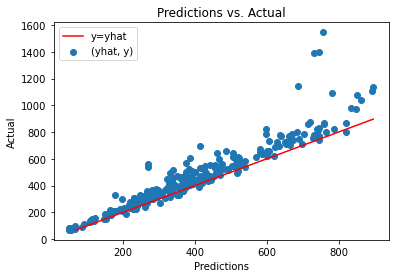

In [119]:
#evaluating with the test set from the train-test split
jae_min_did_nothing(exp_one_first_model, X_te, y_te, X_tr, y_tr) #summary plot

In [120]:
X_fm_ex_1, y_fm_ex_1 = pre_lock_down_model_one(exp_one_first_model_df, evaluatable_data)

R^2 is 0.8703353154167037
MAE is 65.30897370286445
MSE is 5622.464601006807
RMSE is 74.98309543494992
CV RMSE is 95.36289776974122


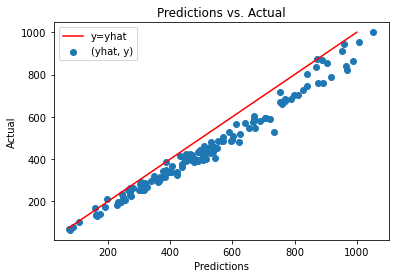

In [121]:
#evaluating with the uniform data to test
jae_min_did_nothing(exp_one_first_model, X_fm_ex_1, np.array(y_fm_ex_1), X_tr, y_tr)

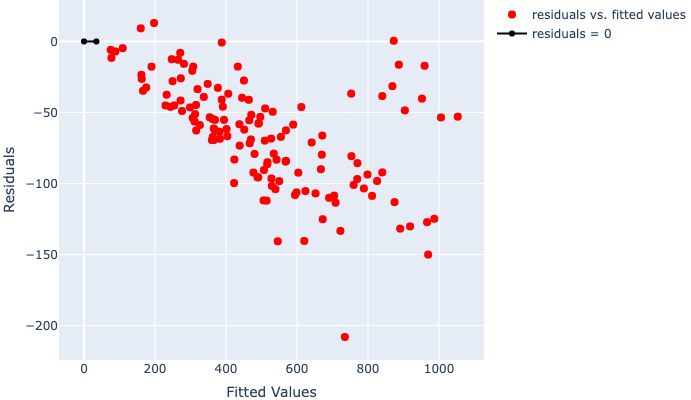

In [122]:
please_give_jaemin_zero(y_fm_ex_1, exp_one_first_model.predict(X_fm_ex_1))

EXP One Second Model

In [123]:
X_sm_ex_1, y_sm_ex_1 = data_uwu(exp_one_merged_df, evaluatable_data)

In [124]:
tr, te = train_test_split(exp_one_merged_df, test_size=0.20, random_state=83)

In [125]:
tr, te = remove_uncomparable_dest(tr, te, "Destination City")

In [126]:
tr_sm = drop_cols(tr)
te_sm = drop_cols(te)
X_sm_ex_1_sm = drop_cols(X_sm_ex_1)

R^2 is 0.9701049168258961
MAE is 53.20775183833575
MSE is 8061.249234127937
RMSE is 89.78445986989027
CV RMSE is 86.25003377510467


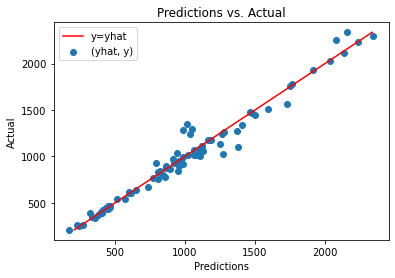

In [127]:
#evaluating with the test set from the train-test split
exp_one_second_model = LinearRegression()
exp_one_second_model = exp_one_second_model.fit(tr_sm, tr["Post Lock Down Mean Travel Time"])
jae_min_did_nothing(exp_one_second_model, te_sm, te["Post Lock Down Mean Travel Time"], tr_sm, tr["Post Lock Down Mean Travel Time"])

R^2 is 0.9840838043989185
MAE is 18.80223548742443
MSE is 699.1868846801971
RMSE is 26.442142210497945
CV RMSE is 86.25003377510467


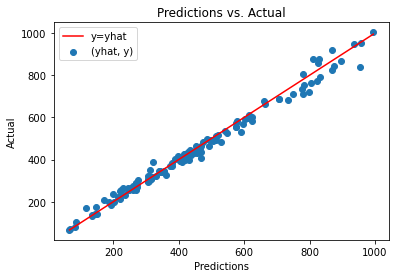

In [128]:
#evaluating with the uniform data to test
jae_min_did_nothing(exp_one_second_model, X_sm_ex_1_sm, y_sm_ex_1, tr_sm, tr["Post Lock Down Mean Travel Time"])

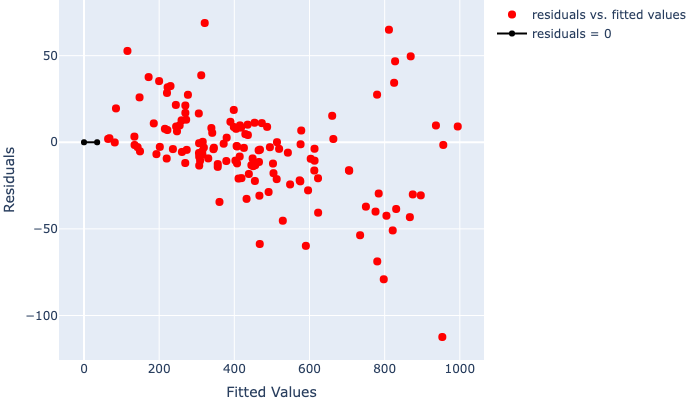

In [129]:
please_give_jaemin_zero(y_sm_ex_1, exp_one_second_model.predict(X_sm_ex_1_sm))

EXP Two First Model

In [130]:
evaluatable_datas_two = all_data_present_exp_two.reset_index()['Destination Movement ID']
evaluatable_data_two = evaluatable_datas_two.tolist()

In [131]:
X_tr_2, y_tr_2, X_te_2, y_te_2 = time_series_to_dataset(exp_two_first_model_df, 13, 2)

In [132]:
exp_two_first_model = LinearRegression()
exp_two_first_model = exp_two_first_model.fit(X_tr_2, y_tr_2)

R^2 is 0.767020311782068
MAE is 49.47534061171832
MSE is 4723.986819044725
RMSE is 68.73126522220237
CV RMSE is 67.72969477340465


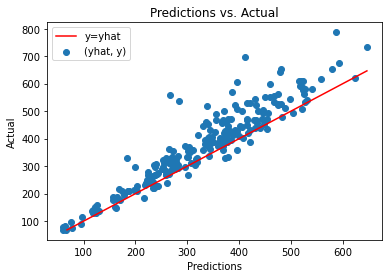

In [133]:
#evaluating with the test set from the train-test split
jae_min_did_nothing(exp_two_first_model, X_te_2, y_te_2, X_tr_2, y_tr_2)

In [134]:
X_fm_ex_2, y_fm_ex_2 = pre_lock_down_model_one(exp_two_first_model_df, evaluatable_data_two)

R^2 is 0.7256640815669431
MAE is 63.99166297242597
MSE is 5086.142563994093
RMSE is 71.31719683213925
CV RMSE is 67.72969477340465


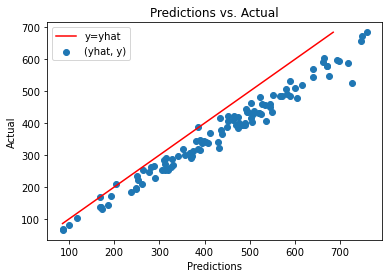

In [135]:
#evaluating with the uniform data to test
jae_min_did_nothing(exp_two_first_model, X_fm_ex_2, np.array(y_fm_ex_2), X_tr_2, y_tr_2)

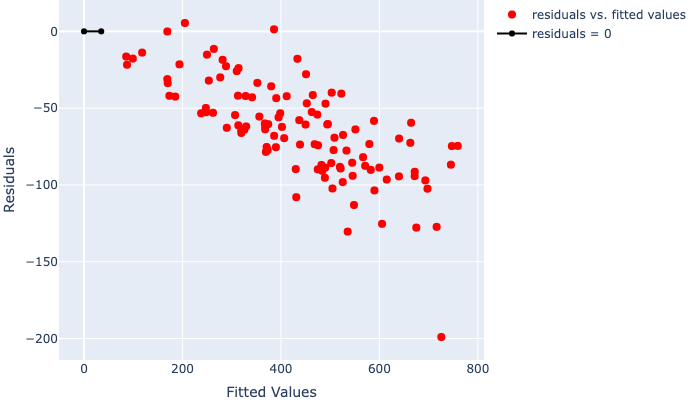

In [136]:
please_give_jaemin_zero(y_fm_ex_2, exp_two_first_model.predict(X_fm_ex_2))

EXP Two Second Model

In [137]:
X_sm_ex_2, y_sm_ex_2 = data_uwu(exp_two_merged_df, evaluatable_data_two)

In [138]:
tr_2, te_2 = train_test_split(exp_two_merged_df, test_size=0.20, random_state=83)

In [139]:
tr_2, te_2 = remove_uncomparable_dest(tr_2, te_2, "Destination Names")

In [140]:
tr_sm_2 = drop_cols_two(tr_2)
te_sm_2 = drop_cols_two(te_2)
X_sm_ex_2_sm = drop_cols_two(X_sm_ex_2)

In [141]:
exp_two_second_model = LinearRegression()
exp_two_second_model = exp_two_second_model.fit(tr_sm_2, tr_2["Post Lock Down Mean Travel Time"])

R^2 is 0.9822643185682428
MAE is 28.9794856972368
MSE is 1583.6767439548287
RMSE is 39.79543622018521
CV RMSE is 70.42476653413766


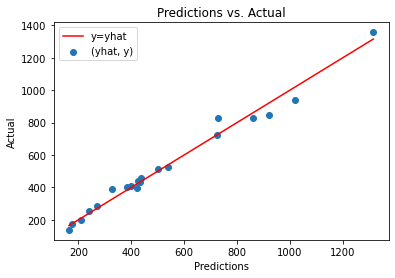

In [142]:
#evaluating with the test set from the train-test split
jae_min_did_nothing(exp_two_second_model, te_sm_2, te_2["Post Lock Down Mean Travel Time"], tr_sm_2, tr_2["Post Lock Down Mean Travel Time"])

R^2 is 0.9805856822221647
MAE is 14.891433189450211
MSE is 347.0221988705656
RMSE is 18.628531849573267
CV RMSE is 70.42476653413766


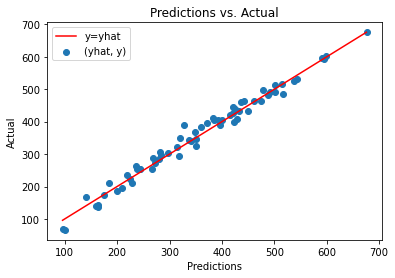

In [143]:
#evaluating with the uniform data to test
jae_min_did_nothing(exp_two_second_model, X_sm_ex_2_sm, y_sm_ex_2, tr_sm_2, tr_2["Post Lock Down Mean Travel Time"])

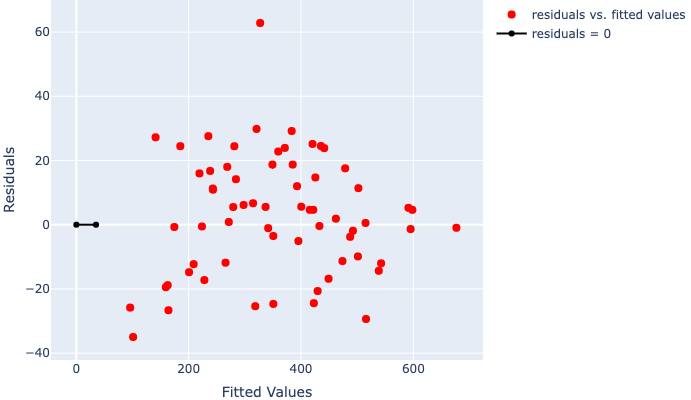

In [144]:
please_give_jaemin_zero(y_sm_ex_2, exp_two_second_model.predict(X_sm_ex_2_sm))

END of Part A 

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

In [145]:
def impute_first_model_daily_avg(df):
    daily_avg = df.mean()
    Phi = df.copy()
    for i in range(1, len(Phi.columns)+1, 1):
        Phi[i] = Phi[i].fillna(daily_avg[i])
    return Phi

def drop_too_many_nan(df):
    Phi = df.copy()
    Phi = Phi.reset_index()
    keep = np.array(0)
    for i in range(len(Phi)):
            if(np.sum(np.isnan(Phi.iloc[i])) < 15):
                keep = np.append(keep, Phi["Destination Movement ID"][i])
            keep.tolist()
    Phi = Phi[Phi["Destination Movement ID"].isin(keep)] 
    Phi = Phi.set_index("Destination Movement ID")
    return Phi

def impute_first_model_loc_avg(df):
    Phi = df.copy()
    Phi = Phi.reset_index()
    for i in range(len(Phi)):
        Phi.iloc[i] = Phi.iloc[i].fillna(np.mean(Phi.iloc[i]))
    Phi = Phi.set_index("Destination Movement ID")
    return Phi

def impute_first_model_loc_pre_post_avg(df):
    Phi = df.copy()
    Phi = Phi.reset_index()
    for i in range(len(Phi)):
        Phi.iloc[i, :13] = Phi.iloc[i, :13].fillna(np.mean(Phi.iloc[i, :13]))
        Phi.iloc[i, 13:] = Phi.iloc[i, 13:].fillna(np.mean(Phi.iloc[i, 13:]))
    Phi = Phi.set_index("Destination Movement ID")
    return Phi

def phi_curved(X):
    return np.hstack([
        X,
        X * X,
        np.expand_dims(np.prod(X, axis=1), 1),
        X ** 3,
    ])

def phi_natural_log(X):
    return np.hstack([
        X,
        np.log(X),
    ]) 

def phi_periodic(X):
    return np.hstack([
        X,
        np.sin(X),
        np.sin(0.26*X),
        np.sin(X - 6),
        np.sin(0.26 * X - 6),
    ]) 

def phi_log_and_periodic(X):
    return np.hstack([phi_natural_log(X), phi_periodic(X)])

def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

def compare_models(models, tr):
    # Compute the training error for each model
    training_rmse = [rmse_score(model, tr, tr['Post Lock Down Mean Travel Time']) for model in models.values()]
    # Compute the cross validation error for each model
    validation_rmse = [np.mean(cross_val_score(model, tr, tr['Post Lock Down Mean Travel Time'], scoring=rmse_score, cv=5)) 
                       for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_rmse, name="Training RMSE"),
        go.Bar(x = names, y = validation_rmse, name="CV RMSE"),
    ])
    fig.update_yaxes(title="RMSE")
    return fig
        
def compare_r2(models, te):
    rtwo = [model.score(te, te['Post Lock Down Mean Travel Time']) for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([go.Bar(x = names, y = rtwo, name="R^2", opacity=.3)])
    fig.update_yaxes(title="R^2")
    return fig

In [146]:
exp_one_first_model_df_daily_avg = impute_first_model_daily_avg(exp_one_first_model_df)

In [147]:
X_tr_avg, y_tr_avg, X_te_avg, y_te_avg = time_series_to_dataset(exp_one_first_model_df_daily_avg, 13, 2)

R^2 is 0.4932810293154325
MAE is 84.1001214479554
MSE is 22610.70867878048
RMSE is 150.36857610145972
CV RMSE is 195.99142575237266


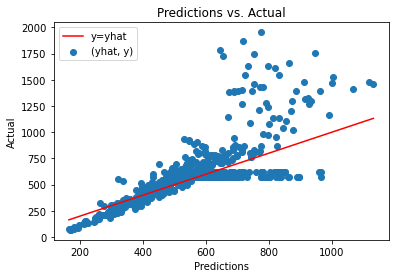

In [148]:
#impute daily average travel time to data
exp_one_first_model_daily_avg = LinearRegression()
exp_one_first_model_daily_avg.fit(X_tr_avg, y_tr_avg)
jae_min_did_nothing(exp_one_first_model_daily_avg, X_te_avg, y_te_avg, X_tr_avg, y_tr_avg)

R^2 is 0.5352008635845631
MAE is 116.96426709678278
MSE is 40957.48586219792
RMSE is 202.37955890405019
CV RMSE is 200.98204610782614


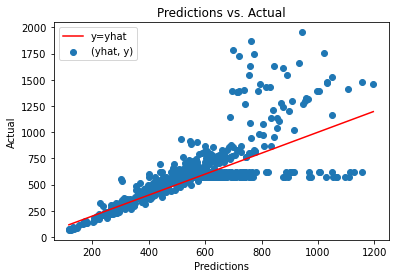

In [149]:
#impute daily average travel time to data with too many NaN destinations dropped
too_many_nan_dropped = drop_too_many_nan(exp_one_first_model_df)
too_many_nan_dropped_impute = impute_first_model_daily_avg(too_many_nan_dropped)
X_tr_avgd, y_tr_avgd, X_te_avgd, y_te_avgd = time_series_to_dataset(too_many_nan_dropped_impute, 13, 2)
too_many_nan_dropped_lm = LinearRegression()
too_many_nan_dropped_lm.fit(X_tr_avgd, y_tr_avgd)
jae_min_did_nothing(too_many_nan_dropped_lm, X_te_avgd, y_te_avgd, X_tr_avgd, y_tr_avgd)

R^2 is 0.9850115581994796
MAE is 42.23991107102383
MSE is 7163.515419013902
RMSE is 84.63755324330862
CV RMSE is 85.97281440057182


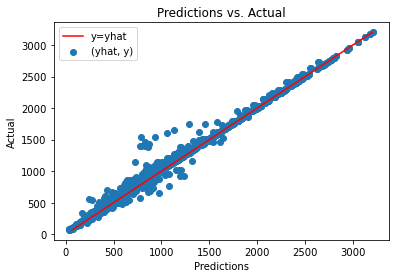

In [150]:
#impute location average travel time to data
exp_one_first_model_df_loc_avg = impute_first_model_loc_avg(exp_one_first_model_df)
X_tr_loc, y_tr_loc, X_te_loc, y_te_loc = time_series_to_dataset(exp_one_first_model_df_loc_avg, 13, 2)
exp_one_first_model_loc_avg = LinearRegression()
exp_one_first_model_loc_avg.fit(X_tr_loc, y_tr_loc)
jae_min_did_nothing(exp_one_first_model_loc_avg, X_te_loc, y_te_loc, X_tr_loc, y_tr_loc)

R^2 is 0.9348282097614632
MAE is 81.75153118440504
MSE is 15539.625427116649
RMSE is 124.65803394533643
CV RMSE is 108.74002171139907


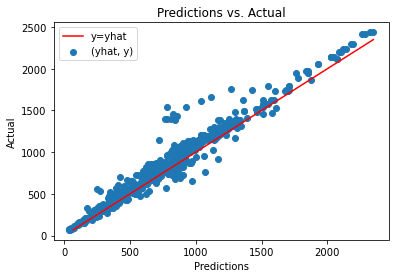

In [151]:
#impute location average travel time to data with too many NaN destinations dropped
too_many_nan_dropped_impute_loc = impute_first_model_loc_avg(too_many_nan_dropped)
X_tr_locd, y_tr_locd, X_te_locd, y_te_locd = time_series_to_dataset(too_many_nan_dropped_impute_loc, 13, 2)
too_many_nan_dropped_loc_lm = LinearRegression()
too_many_nan_dropped_loc_lm.fit(X_tr_locd, y_tr_locd)
jae_min_did_nothing(too_many_nan_dropped_loc_lm, X_te_locd, y_te_locd, X_tr_locd, y_tr_locd)

R^2 is 0.9757095730022628
MAE is 43.320719979962405
MSE is 7858.850307967855
RMSE is 88.65015684119152
CV RMSE is 87.89677506401446


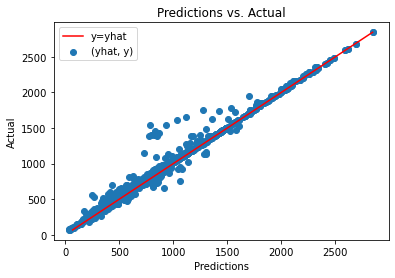

In [152]:
#impute location pre-lockdown average travel time and post-locdown average travel time
exp_one_first_model_df_loc_pre_post_avg = impute_first_model_loc_pre_post_avg(exp_one_first_model_df)
X_tr_loc_pp, y_tr_loc_pp, X_te_loc_pp, y_te_loc_pp = time_series_to_dataset(exp_one_first_model_df_loc_pre_post_avg, 13, 2)
exp_one_first_model_loc_avg_pp = LinearRegression()
exp_one_first_model_loc_avg_pp.fit(X_tr_loc, y_tr_loc)
jae_min_did_nothing(exp_one_first_model_loc_avg_pp, X_te_loc_pp, y_te_loc_pp, X_tr_loc_pp, y_tr_loc_pp)

**Non - Linear Models**

R^2 is -0.4290588102332282
MAE is 244.8389168678757
MSE is 81908.70795539803
RMSE is 286.19697405003785
CV RMSE is 370.87088616742665


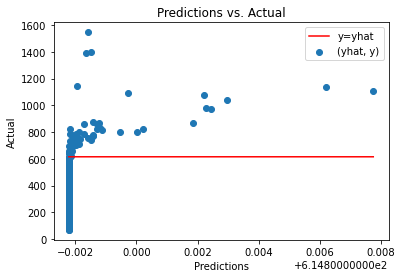

In [153]:
#polynomial
curvedX_tr = phi_curved(X_tr)
curvedX_te = phi_curved(X_te)
curved = LinearRegression()
curved = curved.fit(curvedX_tr, y_tr)
jae_min_did_nothing(curved, curvedX_te, y_te, curvedX_tr, y_tr)

R^2 is 0.7785942442969112
MAE is 69.12063616883668
MSE is 12690.212084811814
RMSE is 112.6508414740512
CV RMSE is 96.19009181543352


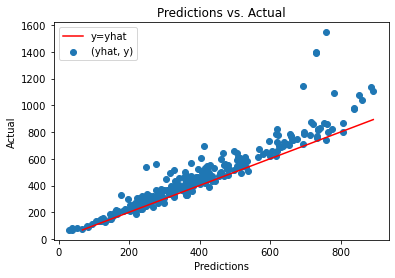

In [154]:
#sinusoidal
sinuX_tr = phi_periodic(X_tr)
sinuX_te = phi_periodic(X_te)
sinu = LinearRegression()
sinu = sinu.fit(sinuX_tr, y_tr)
jae_min_did_nothing(sinu, sinuX_te, y_te, sinuX_tr, y_tr)

R^2 is 0.7721753095524378
MAE is 71.31916940787116
MSE is 13058.12322157183
RMSE is 114.27214543173604
CV RMSE is 96.19709265529285


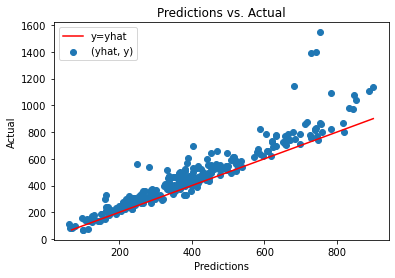

In [155]:
#long
logX_tr = phi_natural_log(X_tr)
logX_te = phi_natural_log(X_te)
log = LinearRegression()
log = log.fit(logX_tr, y_tr)
jae_min_did_nothing(log, logX_te, y_te, logX_tr, y_tr)

R^2 is 0.7688144793786156
MAE is 72.56359446960498
MSE is 13250.754382181913
RMSE is 115.11192111237617
CV RMSE is 96.98909426642372


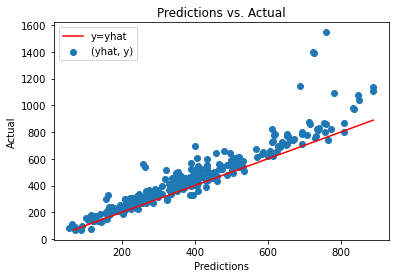

In [156]:
#log and sinusoidal
sinu_logX_tr = phi_log_and_periodic(X_tr)
sinu_logX_te = phi_log_and_periodic(X_te)
sinu_log = LinearRegression()
sinu_log = sinu_log.fit(sinu_logX_tr, y_tr)
jae_min_did_nothing(sinu_log, sinu_logX_te, y_te, sinu_logX_tr, y_tr)

R^2 is 0.9850040420865968
MAE is 42.54728782481701
MSE is 7167.107639689294
RMSE is 84.65877178231027
CV RMSE is 86.32433003736077


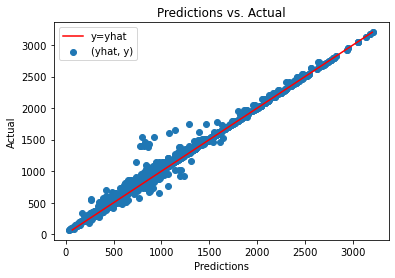

In [157]:
#sinusoidal with location average travel time imputed
sinuX_tr_2 = phi_periodic(X_tr_loc)
sinuX_te_2 = phi_periodic(X_te_loc)
sinu_2 = LinearRegression()
sinu_2 = sinu_2.fit(sinuX_tr_2, y_tr_loc)
jae_min_did_nothing(sinu_2, sinuX_te_2, y_te_loc, sinuX_tr_2, y_tr_loc)

R^2 is 0.7447199875133601
MAE is 93.25536143197536
MSE is 11069.342729389613
RMSE is 105.21094396206895
CV RMSE is 85.97281440057182


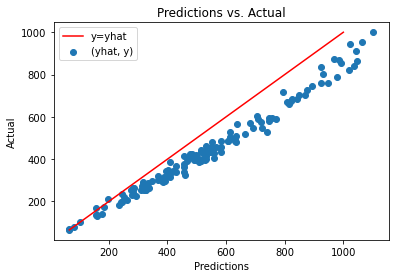

In [158]:
#evaluating with uniform test data with new model
jae_min_did_nothing(exp_one_first_model_loc_avg, X_fm_ex_1, np.array(y_fm_ex_1), X_tr_loc, y_tr_loc)

**Experiement Two**

In [159]:
#del models
models = {}

In [160]:
quantitative_features = ["Mean Travel Time Pre Lock Down", "Lower Mean Travel Time Pre Lock Down", "Upper Mean Travel Time Pre Lock Down", "Number of Total Rides Pre Lock Down"]

In [161]:
for i in range(len(quantitative_features)):
    # The features to include in the ith model
    features = quantitative_features[:(i+1)]
    # The name we are giving to the ith model
    name = ",".join([name[0] for name in features])
    # The pipeline for the ith model
    model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", features),
        ])),
        ("Imputation", SimpleImputer()),
        ("LinearModel", LinearRegression())
    ])
    # Fit the pipeline
    model.fit(tr, tr['Post Lock Down Mean Travel Time']);
    # Saving the ith model
    models[name] = model
models.keys()

dict_keys(['M', 'M,L', 'M,L,U', 'M,L,U,N'])

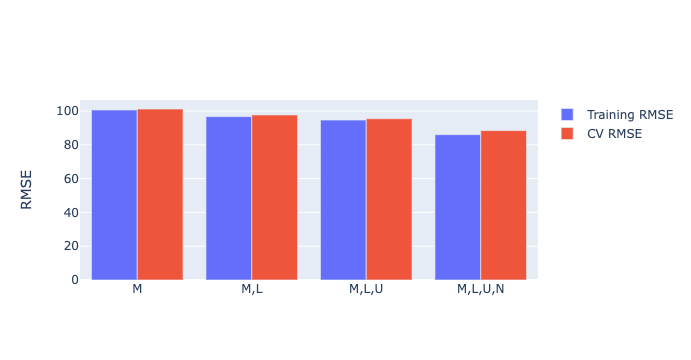

In [162]:
compare_models(models, tr)

Dest City

In [163]:
model_two = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("dest_encoder", OneHotEncoder(handle_unknown='ignore'), ["Destination City"])
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

In [164]:
model_two.fit(tr, tr['Post Lock Down Mean Travel Time'])
name = ",".join([name[0] for name in quantitative_features]) + ",D"
models[name] = model_two

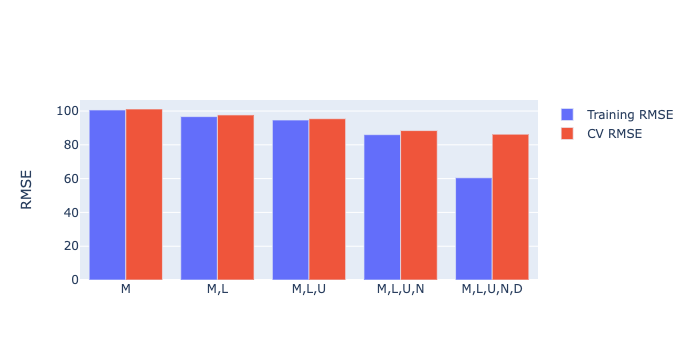

In [165]:
compare_models(models, tr)

In [166]:
model_three = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", "passthrough", quantitative_features),
        ("dest_encoder", OneHotEncoder(handle_unknown='ignore'), ["Destination City"]),
        ("bridge_encoder", OneHotEncoder(handle_unknown='ignore'), ["Cross Bridge"])
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel", LinearRegression())
])

In [167]:
model_three.fit(tr, tr['Post Lock Down Mean Travel Time'])
name = ",".join([name[0] for name in quantitative_features]) + ",D" + ",B"
models[name] = model_three

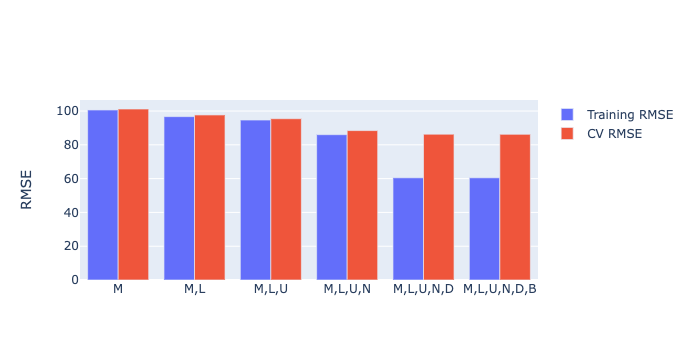

In [168]:
compare_models(models, tr)

Ridge Regression

In [169]:
alphas = np.linspace(0.5, 3, 30)
ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("dest_encoder", OneHotEncoder(handle_unknown='ignore'), ["Destination City"]),
        ("bridge_encoder", OneHotEncoder(handle_unknown='ignore'), ["Cross Bridge"])
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel",  RidgeCV(alphas=alphas))
])

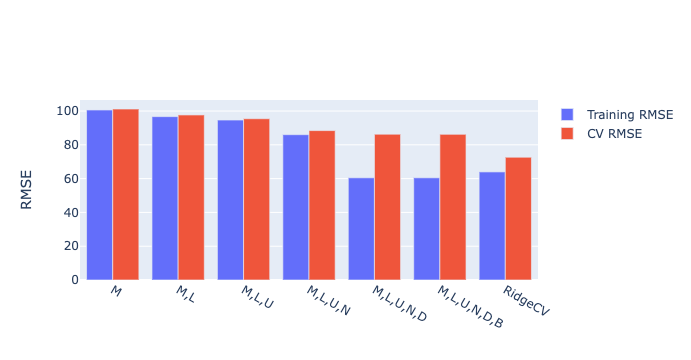

In [170]:
ridge_model.fit(tr, tr['Post Lock Down Mean Travel Time'])
models["RidgeCV"] = ridge_model
compare_models(models, tr)

LASSO

In [171]:
lasso_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features),
        ("dest_encoder", OneHotEncoder(handle_unknown='ignore'), ["Destination City"]),
        ("bridge_encoder", OneHotEncoder(handle_unknown='ignore'), ["Cross Bridge"])
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel",  LassoCV(cv=3, tol = 2e-4))
])

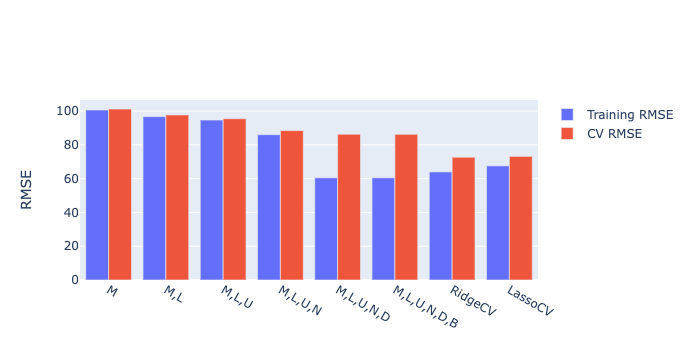

In [172]:
lasso_model.fit(tr, tr['Post Lock Down Mean Travel Time'])
models["LassoCV"] = lasso_model
compare_models(models, tr)

In [173]:
ct = models['LassoCV']['SelectColumns']
feature_names = (
    quantitative_features +
    list(ct.named_transformers_['dest_encoder'].get_feature_names())+
    list(ct.named_transformers_['bridge_encoder'].get_feature_names())
)
feature_names = np.array(feature_names)
print(feature_names)

['Mean Travel Time Pre Lock Down' 'Lower Mean Travel Time Pre Lock Down'
 'Upper Mean Travel Time Pre Lock Down'
 'Number of Total Rides Pre Lock Down' 'x0_ Berkeley' 'x0_ Burlingame'
 'x0_ Daly City' 'x0_ Emeryville' 'x0_ Lafayette' 'x0_ Millbrae'
 'x0_ Mountain View' 'x0_ Novato' 'x0_ Oakland' 'x0_ Orinda'
 'x0_ Pacifica' 'x0_ Redwood City' 'x0_ Richmond' 'x0_ San Bruno'
 'x0_ San Francisco' 'x0_ San Leandro' 'x0_ San Mateo' 'x0_ San Rafael'
 'x0_ Santa Clara' 'x0_ Sausalito' 'x0_ South San Francisco'
 'x0_ Sunnyvale' 'x0_ Walnut Creek' 'x0_Bay Bridge' 'x0_No Bridge']


In [174]:
kept = ~np.isclose(models['LassoCV']["LinearModel"].coef_, 0)
important_features = feature_names[kept]
important_features

array(['Mean Travel Time Pre Lock Down',
       'Lower Mean Travel Time Pre Lock Down',
       'Upper Mean Travel Time Pre Lock Down',
       'Number of Total Rides Pre Lock Down', 'x0_ Oakland',
       'x0_ Pacifica', 'x0_ Richmond', 'x0_ San Bruno',
       'x0_ San Francisco', 'x0_ San Rafael', 'x0_ Sunnyvale',
       'x0_ Walnut Creek'], dtype='<U36')

In [175]:
lasso_tr = tr[important_features]
lasso_te = te[important_features]
lasso_X_sm_ex_1_sm = X_sm_ex_1_sm[important_features]

In [176]:
lasso_first_exp_model = LinearRegression()
lasso_first_exp_model = lasso_first_exp_model.fit(lasso_tr, tr["Post Lock Down Mean Travel Time"])

R^2 is 0.960021406191377
MAE is 61.91695218171955
MSE is 10780.281387557452
RMSE is 103.82813389230037
CV RMSE is 72.66975200975581


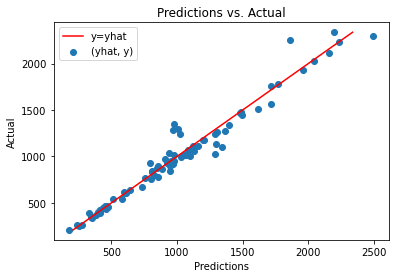

In [177]:
#evaluating on test data from test-train split 
jae_min_did_nothing(lasso_first_exp_model, lasso_te, te["Post Lock Down Mean Travel Time"], lasso_tr, tr["Post Lock Down Mean Travel Time"])

R^2 is 0.9850840658401862
MAE is 19.102554064124146
MSE is 655.2461278238209
RMSE is 25.59777583743988
CV RMSE is 72.66975200975581


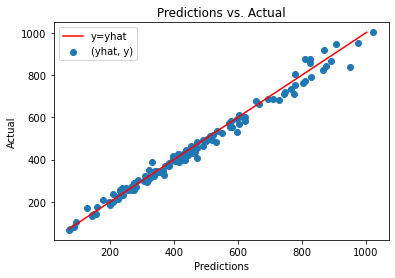

In [178]:
#evaluating on uniform data to test
jae_min_did_nothing(lasso_first_exp_model, lasso_X_sm_ex_1_sm, np.array(y_sm_ex_1), lasso_tr, tr["Post Lock Down Mean Travel Time"])

Adding Annual Average Daily Traffic

In [179]:
tract_to_gps_2 = tract_to_gps.copy()
tract_to_gps_2["geometry string"] = tract_to_gps_2["geometry"].astype(str)
tract_to_gps_t = tract_to_gps_2[["MOVEMENT_ID", "geometry string"]]
lat_logs = tract_to_gps_t["geometry string"].str.extract(r'\(\(\((-\d{3}\.\d{4}\d?\d?.\d{2}.\d{2}\d?\d?\d?\d?),', expand = True)
lat_and_long = lat_logs[0].str.split(' ', expand = True)
long = lat_and_long[[0]].reset_index().rename(columns = {0 : 'longitude'})
lat = lat_and_long[[1]].reset_index().rename(columns = {1 : 'latitude'})
long["longitude"] = long["longitude"].astype(float)
lat["latitude"] = lat["latitude"].astype(float)

In [180]:
exp_one_merged_df_long = exp_one_merged_df.merge(long, left_on = "Destination Movement ID", right_on = "index", how = "left")
exp_one_merged_df_lat_long =exp_one_merged_df_long.merge(lat, left_on = "Destination Movement ID", right_on = "index", how = "left")
improved_exp_one_merged_df = exp_one_merged_df_lat_long.drop(columns ={"index_x", "index_y"})
improved_exp_one_merged_df.head(3)

Destination Movement ID  Post Lock Down Mean Travel Time  \
0                        9                       253.777778   
1                       20                       228.888889   
2                       21                       472.200000   

   Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
0                      343.615385                            225.076923   
1                      319.461538                            199.769231   
2                      622.153846                            463.692308   

   Upper Mean Travel Time Pre Lock Down  Number of Total Rides Pre Lock Down  \
0                            523.461538                                 13.0   
1                            509.384615                                 13.0   
2                            835.307692                                 13.0   

                            Destination Display Name Destination City  \
0         500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco    San Francisco   
2  3400 Pierce Street, Marina District, San Franc...    San Francisco   

                  Destination Names  x0_ Alameda  ...  x0_ Sunnyvale  \
0        Tenderloin,  San Francisco          0.0  ...            0.0   
1    Lower Nob Hill,  San Francisco          0.0  ...            0.0   
2   Marina District,  San Francisco          0.0  ...            0.0   

   x0_ Walnut Creek  x0_ Woodside  Cross Bridge  x0_Bay Bridge  \
0               0.0           0.0     No Bridge            0.0   
1               0.0           0.0     No Bridge            0.0   
2               0.0           0.0     No Bridge            0.0   

   x0_Golden Gate Bridge  x0_No Bridge  x0_San Mateo Hayward Bridge  \
0                    0.0           1.0                          0.0   
1                    0.0           1.0                          0.0   
2                    0.0           1.0                          0.0   

    longitude   latitude  
0 -121.074410  37.699985  
1 -122.441905  37.803744  
2 -121.346363  35.795183  

[3 rows x 69 columns]

In [181]:
start_long = long.iloc[1277, 1]
start_lat = lat.iloc[1277, 1]

In [182]:
bay_area = traffic_volume_data[traffic_volume_data["District"] == 4]
bay_area.head()

OBJECTID  District Route County Postmile  \
190       191         4     1     SM        0   
191       192         4     1     SM   13.579   
192       193         4     1     SM   18.189   
193       194         4     1     SM    20.98   
194       195         4     1     SM    23.06   

                            Descriptn  Back_p_h  Back_pk_m  Back_AADT  \
190  SANTA CRUZ/SAN MATEO COUNTY LINE         0          0          0   
191  PEBBLE BEACH ROAD (TO PESCADERO)       700       5300       4200   
192                 JCT. RTE. 84 EAST      1400       9400       7700   
193                TUNITAS CREEK ROAD      1200       8900       7400   
194                  MEYN/VERDE ROADS      1300      10400       8400   

     Ahead_pk_h  Ahead_pk_m  Ahead_AADT  Lat_S_or_W  Lon_S_or_W  Lat_N_or_E  \
190           0           0        5400   37.107687 -122.292659   37.107687   
191        1300       10000        7900   37.259772 -122.413184   37.259772   
192        1200        9100        7600   37.324496 -122.399902   37.324496   
193        1400       10700        8700   37.358795 -122.397646   37.358795   
194        1300       10900        8600   37.386996 -122.405576   37.386997   

     Lon_N_or_E  
190 -122.292659  
191 -122.413184  
192 -122.399902  
193 -122.397646  
194 -122.405577

In [183]:
baaay_area = bay_area.copy()
baaay_area["Lat"] = bay_area["Lat_S_or_W"].astype(float)
baaay_area["Long"] = bay_area["Lon_S_or_W"].astype(float)
useful = baaay_area[["Ahead_AADT", "Lat", "Long"]]
useful_two = improved_exp_one_merged_df[["Destination Movement ID", "longitude", "latitude"]]

In [184]:
mean_AADTs = [0] * len(useful_two)
median_AADTs = [0] * len(useful_two)
total_AADTs = [0] * len(useful_two)
for i in range(len(useful_two)):
    if(useful_two["longitude"][i] > start_long):
        up_long = useful_two["longitude"][i]
        down_long = start_long
    else:
        up_long = start_long
        down_long = useful_two["longitude"][i]
    if(useful_two["latitude"][i] > start_lat):
        up_lat = useful_two["latitude"][i]
        down_lat = start_lat
    else:
        up_lat = start_lat
        down_lat = useful_two["latitude"][0]
    lat_range = useful[(useful["Lat"] >= down_lat) & (useful["Lat"] <= up_lat)]
    lat_long_range = lat_range[(lat_range["Long"] >= down_long) & (lat_range["Long"] <= up_long)]
    mean_AADT = np.mean(lat_long_range["Ahead_AADT"])
    median_AADT = np.median(lat_long_range["Ahead_AADT"])
    total_AADT = np.sum(lat_long_range["Ahead_AADT"])
    mean_AADTs[i] = mean_AADT
    median_AADTs[i] = median_AADT
    total_AADTs[i] = total_AADT

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



In [185]:
improved_exp_one_merged_df["Mean AADT"] = mean_AADTs
improved_exp_one_merged_df["Median AADT"] = median_AADTs
improved_exp_one_merged_df["Total AADT"] = total_AADTs
improved_exp_one_merged_df.head(3)

Destination Movement ID  Post Lock Down Mean Travel Time  \
0                        9                       253.777778   
1                       20                       228.888889   
2                       21                       472.200000   

   Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
0                      343.615385                            225.076923   
1                      319.461538                            199.769231   
2                      622.153846                            463.692308   

   Upper Mean Travel Time Pre Lock Down  Number of Total Rides Pre Lock Down  \
0                            523.461538                                 13.0   
1                            509.384615                                 13.0   
2                            835.307692                                 13.0   

                            Destination Display Name Destination City  \
0         500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco    San Francisco   
2  3400 Pierce Street, Marina District, San Franc...    San Francisco   

                  Destination Names  x0_ Alameda  ...  Cross Bridge  \
0        Tenderloin,  San Francisco          0.0  ...     No Bridge   
1    Lower Nob Hill,  San Francisco          0.0  ...     No Bridge   
2   Marina District,  San Francisco          0.0  ...     No Bridge   

   x0_Bay Bridge  x0_Golden Gate Bridge  x0_No Bridge  \
0            0.0                    0.0           1.0   
1            0.0                    0.0           1.0   
2            0.0                    0.0           1.0   

   x0_San Mateo Hayward Bridge   longitude   latitude      Mean AADT  \
0                          0.0 -121.074410  37.699985  110987.012987   
1                          0.0 -122.441905  37.803744            NaN   
2                          0.0 -121.346363  35.795183  110987.012987   

   Median AADT  Total AADT  
0     119300.0     8546000  
1          NaN           0  
2     119300.0     8546000  

[3 rows x 72 columns]

In [186]:
imp_tr, imp_te = train_test_split(improved_exp_one_merged_df, test_size=0.15, random_state=83)
imp_tr, imp_te = remove_uncomparable_dest(imp_tr, imp_te, "Destination City")

In [187]:
#del imp_models
imp_models = {}
quantitative_features_two = ["Mean Travel Time Pre Lock Down", "Lower Mean Travel Time Pre Lock Down", "Upper Mean Travel Time Pre Lock Down", "Number of Total Rides Pre Lock Down", "longitude", "latitude", "Mean AADT", "Median AADT", "Total AADT"]

In [188]:
for i in range(len(quantitative_features_two)):
    # The features to include in the ith model
    features = quantitative_features_two[:(i+1)]
    # The name we are giving to the ith model
    name = ",".join([name[0] for name in features])
    # The pipeline for the ith model
    model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", "passthrough", features),
        ])),
        ("Imputation", SimpleImputer()),
        ("LinearModel", LinearRegression())
    ])
    # Fit the pipeline
    model.fit(imp_tr, imp_tr['Post Lock Down Mean Travel Time']);
    # Saving the ith model
    imp_models[name] = model
imp_models.keys()

dict_keys(['M', 'M,L', 'M,L,U', 'M,L,U,N', 'M,L,U,N,l', 'M,L,U,N,l,l', 'M,L,U,N,l,l,M', 'M,L,U,N,l,l,M,M', 'M,L,U,N,l,l,M,M,T'])

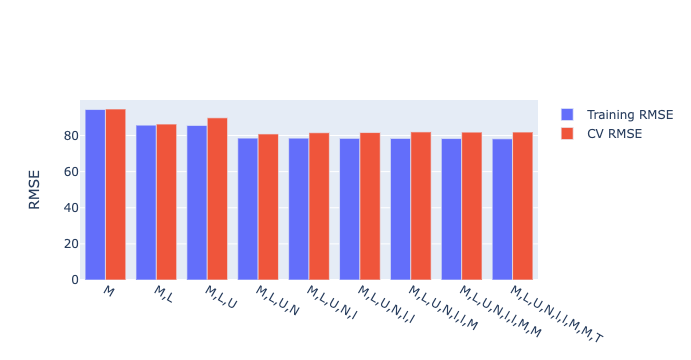

In [189]:
compare_models(imp_models, imp_tr)

In [190]:
imp_lasso_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), quantitative_features_two),
        ("dest_encoder", OneHotEncoder(handle_unknown='ignore'), ["Destination City"]),
        ("bridge_encoder", OneHotEncoder(handle_unknown='ignore'), ["Cross Bridge"])
    ])),
    ("Imputation", SimpleImputer()),
    ("LinearModel",  LassoCV(cv=3))
])

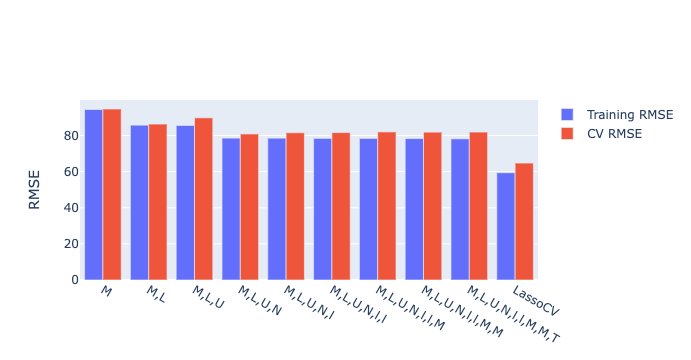

In [191]:
imp_lasso_model.fit(imp_tr, imp_tr['Post Lock Down Mean Travel Time'])
imp_models["LassoCV"] = imp_lasso_model
compare_models(imp_models, imp_tr)

In [192]:
ct_imp = imp_models['LassoCV']['SelectColumns']
feature_names_two = (
    quantitative_features_two +
    list(ct_imp.named_transformers_['dest_encoder'].get_feature_names())+
    list(ct_imp.named_transformers_['bridge_encoder'].get_feature_names())
)
feature_names_two = np.array(feature_names_two)
print(feature_names_two)

['Mean Travel Time Pre Lock Down' 'Lower Mean Travel Time Pre Lock Down'
 'Upper Mean Travel Time Pre Lock Down'
 'Number of Total Rides Pre Lock Down' 'longitude' 'latitude' 'Mean AADT'
 'Median AADT' 'Total AADT' 'x0_ Berkeley' 'x0_ Burlingame'
 'x0_ Emeryville' 'x0_ Millbrae' 'x0_ Mountain View' 'x0_ Novato'
 'x0_ Oakland' 'x0_ Redwood City' 'x0_ San Bruno' 'x0_ San Francisco'
 'x0_ San Leandro' 'x0_ San Mateo' 'x0_ San Rafael' 'x0_ Santa Clara'
 'x0_ South San Francisco' 'x0_ Sunnyvale' 'x0_Bay Bridge' 'x0_No Bridge']


In [193]:
kept_imp = ~np.isclose(imp_models['LassoCV']["LinearModel"].coef_, 0)
important_features_two = feature_names_two[kept_imp]
important_features_two

array(['Mean Travel Time Pre Lock Down',
       'Lower Mean Travel Time Pre Lock Down',
       'Number of Total Rides Pre Lock Down', 'latitude', 'Mean AADT',
       'Total AADT', 'x0_ Berkeley', 'x0_ Novato', 'x0_ Oakland',
       'x0_ San Bruno', 'x0_ San Francisco', 'x0_ San Mateo',
       'x0_ San Rafael', 'x0_ South San Francisco', 'x0_ Sunnyvale'],
      dtype='<U36')

In [194]:
imp_tr = imp_tr.dropna()
imp_te = imp_te.dropna()
imp_lasso_tr = imp_tr[important_features_two]
imp_lasso_te = imp_te[important_features_two]
imp_lasso_first_exp_model = LinearRegression()
imp_lasso_first_exp_model = imp_lasso_first_exp_model.fit(imp_lasso_tr, imp_tr["Post Lock Down Mean Travel Time"])

R^2 is 0.9742397504263896
MAE is 53.231055371130594
MSE is 7842.411255640615
RMSE is 88.55738961622917
CV RMSE is 67.96579273602542


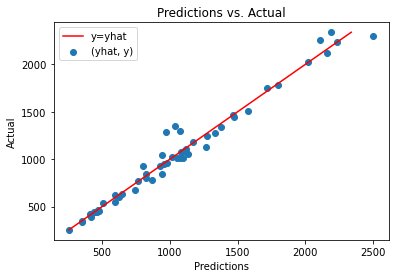

In [195]:
jae_min_did_nothing(imp_lasso_first_exp_model, imp_lasso_te, imp_te["Post Lock Down Mean Travel Time"], imp_lasso_tr,  imp_tr["Post Lock Down Mean Travel Time"])

R^2 is 0.9828774132979126
MAE is 21.136738394422576
MSE is 808.265022199431
RMSE is 28.430002149128146
CV RMSE is 67.96579273602542


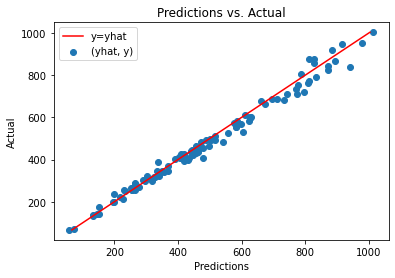

In [196]:
#evaluating on uniform data to test
X_sm_ex_1_lasso, y_sm_ex_1_lasso = data_uwu(improved_exp_one_merged_df.dropna(), evaluatable_data)
X_sm_ex_1_lasso_sm = drop_cols(X_sm_ex_1_lasso)
imp_lasso_tr_X_sm = X_sm_ex_1_lasso_sm[important_features_two]
jae_min_did_nothing(imp_lasso_first_exp_model, imp_lasso_tr_X_sm, np.array(y_sm_ex_1_lasso), imp_lasso_tr, imp_tr["Post Lock Down Mean Travel Time"])

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

In [197]:
merged_pre_post.head()

Destination Display Name  \
0   0 Avoca Alley, West of Twin Peaks, San Francisco   
1               0 Bass Court, Bayview, San Francisco   
2     0 Berkeley Way, Diamond Heights, San Francisco   
3          0 Bernard Street, Nob Hill, San Francisco   
4  0 Brookdale Avenue, Visitacion Valley, San Fra...   

   Mean Travel Time (Seconds) Pre  Mean Travel Time (Seconds) Post  \
0                     1016.230769                       847.500000   
1                      999.923077                       699.571429   
2                      948.769231                       788.666667   
3                      507.000000                       367.888889   
4                     1096.000000                       781.000000   

   difference   % Change  
0  168.730769  16.603588  
1  300.351648  30.037475  
2  160.102564  16.874764  
3  139.111111  27.438089  
4  315.000000  28.740876

## First Exploration: Predicting Percent Change of Mean Travel Time of Pre-lock down and Mean Travel Time of Post-lock down. 


### Dataset Prepare

In [198]:
unique_tracts = times_to_tract.groupby("Destination Display Name")["Mean Travel Time (Seconds)"].mean().reset_index()
avg_travel_by_day_count = times_to_tract.groupby('day')["Mean Travel Time (Seconds)"].count().reset_index().rename(columns = {"Mean Travel Time (Seconds)" : "Number of Travels per Day"})
m_t_a = times_to_tract.merge(avg_travel_by_day_count, how = 'left', left_on = 'day', right_on = 'day')
m_t_a_p = m_t_a.merge(merged_pre_post, how = 'left', left_on = 'Destination Display Name', right_on = 'Destination Display Name')

m_t_a_p.head()
lr_dataset = m_t_a_p[['Mean Travel Time (Seconds)','day','Number of Travels per Day','% Change']]
lr_dataset = lr_dataset.dropna()
lr_dataset.isna().sum()
lr_dataset
lr_dataset_pre = lr_dataset[lr_dataset['day']<=13]
lr_dataset_post = lr_dataset[lr_dataset['day']>13]
lr_dataset_pre.head(3)

Mean Travel Time (Seconds)  day  Number of Travels per Day   % Change
0                         322    1                        512  26.144815
1                         291    1                        512  28.351660
2                         635    1                        512  24.102374

### Baseline Model

In [199]:
print('correlation btw mean travel time pre and % change: ',np.corrcoef(lr_dataset_pre['% Change'], lr_dataset_pre['Mean Travel Time (Seconds)'])[0][1])
print('correlation btw daily travels per day and % change: ',np.corrcoef(lr_dataset_pre['% Change'], lr_dataset_pre['Number of Travels per Day'])[0][1])


correlation btw mean travel time pre and % change:  -0.458355192402702
correlation btw daily travels per day and % change:  -0.03576173911452728


#### Linear Regression between the number of rides and percentage change

Accuracy (column = Number of Travels per Day):  0.0012789019844954286


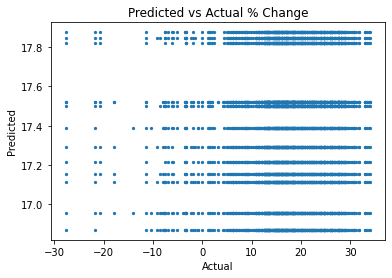

In [200]:
x_train = lr_dataset_pre['Number of Travels per Day'].values.reshape(-1, 1)
y_train = lr_dataset_pre['% Change'].values.reshape(-1, 1)
lr_training_model = LinearRegression()
lr_training_model.fit(x_train,y_train)
training_accuracy = lr_training_model.score(x_train,y_train)
predicted_y = lr_training_model.predict(x_train)


print('Accuracy (column = Number of Travels per Day): ',  training_accuracy)
plt.scatter(y_train,predicted_y, s = 5);
plt.title('Predicted vs Actual % Change')
plt.xlabel('Actual')
plt.ylabel('Predicted');

#### Linear Regression between the Pre Lockdown Mean Travel Time and percentage change

Training Accuracy (column = Pre Mean Travel Time (Seconds)):  0.21008948240251812


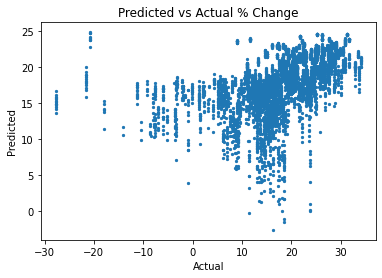

In [201]:
x_train = lr_dataset_pre['Mean Travel Time (Seconds)'].values.reshape(-1, 1)
y_train = lr_dataset_pre['% Change'].values.reshape(-1, 1)
lr_training_model_2 = LinearRegression()
lr_training_model_2.fit(x_train,y_train)
training_accuracy_2 = lr_training_model_2.score(x_train,y_train)
predicted_y_2 = lr_training_model_2.predict(x_train)

print('Training Accuracy (column = Pre Mean Travel Time (Seconds)): ',  training_accuracy_2)
plt.scatter(y_train,predicted_y_2, s = 5);
plt.title('Predicted vs Actual % Change')
plt.xlabel('Actual')
plt.ylabel('Predicted');


### Improving Model

#### Dataframe for better linear regression model to predict percent change

In [205]:
merged_df.head()

Destination Movement ID  Post Lock Down Mean Travel Time  \
0                        9                       253.777778   
1                       20                       228.888889   
2                       21                       472.200000   
3                       44                       643.083333   
4                       46                       876.444444   

   Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
0                      343.615385                            225.076923   
1                      319.461538                            199.769231   
2                      622.153846                            463.692308   
3                      864.846154                            622.615385   
4                     1012.923077                            743.153846   

   Upper Mean Travel Time Pre Lock Down  Number of Total Rides Pre Lock Down  \
0                            523.461538                                 13.0   
1                            509.384615                                 13.0   
2                            835.307692                                 13.0   
3                           1201.923077                                 13.0   
4                           1385.615385                                 13.0   

                            Destination Display Name Destination City  \
0         500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1   900 Sutter Street, Lower Nob Hill, San Francisco    San Francisco   
2  3400 Pierce Street, Marina District, San Franc...    San Francisco   
3         1700 Egbert Avenue, Bayview, San Francisco    San Francisco   
4          500 Chester Street, West Oakland, Oakland          Oakland   

                  Destination Names  
0        Tenderloin,  San Francisco  
1    Lower Nob Hill,  San Francisco  
2   Marina District,  San Francisco  
3           Bayview,  San Francisco  
4            West Oakland,  Oakland

In [206]:
def add_bridge_f(df):
    size = len(df)
    bay = [0]*size
    goldengate = [0]*size
    san_mat_hay = [0]*size
    for x in range(size):
        if ((df["Destination City"][x] == ' Oakland') |
            (df["Destination City"][x] == ' Berkeley') |
            (df["Destination City"][x] == ' Richmond') |
            (df["Destination City"][x] == ' San Leandro') |
            (df["Destination City"][x] == ' Orinda') |
            (df["Destination City"][x] == ' Lafayette') |
            (df["Destination City"][x] == ' Walnut Creek')):
            bay[x] = 1
        if ((df["Destination City"][i] == ' Kentfield') |
            (df["Destination City"][i] == ' Belvedere Tiburon')):
            goldengate[x] = 1
        if (df["Destination City"][i] == ' Hayward'):
            san_mat_hay[x] =  1
    df["Bay Bridge"] =  bay
    df["Golden Gate Bridge"] = goldengate
    df["San Mateo Hayward Bridge"] = san_mat_hay
    return df



oh_enc_f = OneHotEncoder()
oh_enc_f.fit(merged_df[['Destination City']])
dummies_f = pd.DataFrame(oh_enc_f.transform(merged_df[['Destination City']]).todense(), 
                           columns=oh_enc_f.get_feature_names(),
                           index = merged_df.index)
exp_one_merged_df_h_f = merged_df.join(dummies_f)
exp_one_merged_df_f = add_bridge_f(exp_one_merged_df_h_f.reset_index())
exp_one_merged_df_f = exp_one_merged_df_f.dropna().set_index('index')
exp_one_merged_df_f.head()



Destination Movement ID  Post Lock Down Mean Travel Time  \
index                                                             
0                            9                       253.777778   
1                           20                       228.888889   
2                           21                       472.200000   
3                           44                       643.083333   
4                           46                       876.444444   

       Mean Travel Time Pre Lock Down  Lower Mean Travel Time Pre Lock Down  \
index                                                                         
0                          343.615385                            225.076923   
1                          319.461538                            199.769231   
2                          622.153846                            463.692308   
3                          864.846154                            622.615385   
4                         1012.923077                            743.153846   

       Upper Mean Travel Time Pre Lock Down  \
index                                         
0                                523.461538   
1                                509.384615   
2                                835.307692   
3                               1201.923077   
4                               1385.615385   

       Number of Total Rides Pre Lock Down  \
index                                        
0                                     13.0   
1                                     13.0   
2                                     13.0   
3                                     13.0   
4                                     13.0   

                                Destination Display Name Destination City  \
index                                                                       
0             500 Hyde Street, Tenderloin, San Francisco    San Francisco   
1       900 Sutter Street, Lower Nob Hill, San Francisco    San Francisco   
2      3400 Pierce Street, Marina District, San Franc...    San Francisco   
3             1700 Egbert Avenue, Bayview, San Francisco    San Francisco   
4              500 Chester Street, West Oakland, Oakland          Oakland   

                      Destination Names  x0_ Alameda  ...  x0_ San Rafael  \
index                                                 ...                   
0            Tenderloin,  San Francisco          0.0  ...             0.0   
1        Lower Nob Hill,  San Francisco          0.0  ...             0.0   
2       Marina District,  San Francisco          0.0  ...             0.0   
3               Bayview,  San Francisco          0.0  ...             0.0   
4                West Oakland,  Oakland          0.0  ...             0.0   

       x0_ Santa Clara  x0_ Sausalito  x0_ South San Francisco  x0_ Sunnyvale  \
index                                                                           
0                  0.0            0.0                      0.0            0.0   
1                  0.0            0.0                      0.0            0.0   
2                  0.0            0.0                      0.0            0.0   
3                  0.0            0.0                      0.0            0.0   
4                  0.0            0.0                      0.0            0.0   

       x0_ Walnut Creek  x0_ Woodside  Bay Bridge  Golden Gate Bridge  \
index                                                                   
0                   0.0           0.0           0                   0   
1                   0.0           0.0           0                   0   
2                   0.0           0.0           0                   0   
3                   0.0           0.0           0                   0   
4                   0.0           0.0           1                   0   

       San Mateo Hayward Bridge  
index                            
0                             0  
1                             0  
2                             0  


In [207]:
decision_tree_df = exp_one_merged_df_f[['Post Lock Down Mean Travel Time',
                                      'Mean Travel Time Pre Lock Down',
                                      'Lower Mean Travel Time Pre Lock Down',
                                      'Upper Mean Travel Time Pre Lock Down',
                                      'Number of Total Rides Pre Lock Down','Destination Display Name','Destination City',
                                      'Bay Bridge','Golden Gate Bridge','San Mateo Hayward Bridge']]

print('destination cities: ',decision_tree_df['Destination City'].unique())

pre_lockdown_times_to_tract = times_to_tract[times_to_tract["day"] <= 13].groupby("Destination Display Name").mean().reset_index()
post_lockdown_times_to_tract = times_to_tract[times_to_tract["day"] > 13].groupby("Destination Display Name").mean().reset_index()
merged_pre_post_times_to_tract = pre_lockdown_times_to_tract.merge(post_lockdown_times_to_tract, how = "inner", on = "Destination Display Name").rename(columns = {"Mean Travel Time (Seconds)_x" : "Mean Travel Time (Seconds) Pre",
"Mean Travel Time (Seconds)_y" : "Mean Travel Time (Seconds) Post",
'Range - Lower Bound Travel Time (Seconds)_x': 'Range - Lower Bound Travel Time (Seconds) Pre',
'Range - Upper Bound Travel Time (Seconds)_x': 'Range - Upper Bound Travel Time (Seconds)_Pre',
'Range - Lower Bound Travel Time (Seconds)_y': 'Range - Lower Bound Travel Time (Seconds) Post',
'Range - Upper Bound Travel Time (Seconds)_y': 'Range - Upper Bound Travel Time (Seconds)_Post'})
merged_pre_post_times_to_tract =merged_pre_post_times_to_tract.drop(columns = ['Origin Movement ID_x','Destination Movement ID_x',
                                                                               'day_x','Origin Movement ID_y','Destination Movement ID_y',
                                                                               'day_y'])
merged_pre_post_times_to_tract.head()
trying_to = decision_tree_df[['Number of Total Rides Pre Lock Down','Destination Display Name','Destination City','Bay Bridge','Golden Gate Bridge','San Mateo Hayward Bridge']]

final_decision_tree_df = merged_pre_post_times_to_tract.merge(trying_to, on = 'Destination Display Name',how = 'inner')

df_for_lg = final_decision_tree_df.copy()
df_for_lg["difference"] = df_for_lg["Mean Travel Time (Seconds) Pre"] - df_for_lg["Mean Travel Time (Seconds) Post"]
df_for_lg["% Change"] = df_for_lg["difference"]/df_for_lg["Mean Travel Time (Seconds) Pre"] * 100


destination cities:  [' San Francisco' ' Oakland' ' San Pablo' ' Mountain View' ' Pacifica'
 ' San Carlos' ' Berkeley' ' Richmond' ' Hayward' ' Daly City'
 ' Sunnyvale' ' East Palo Alto' ' San Rafael' ' San Leandro'
 ' South San Francisco' ' Redwood City' ' Palo Alto' ' Orinda' ' Colma'
 ' San Mateo' ' Pleasant Hill' ' San Bruno' ' Burlingame' ' Santa Clara'
 ' Castro Valley' ' Lafayette' ' El Sobrante' ' Lakeshore' ' Belmont'
 ' Bolinas' ' Walnut Creek' ' El Cerrito' ' Albany' ' Emeryville'
 ' San Lorenzo' ' Larkspur' ' Corte Madera' ' Mill Valley' ' Woodside'
 ' Menlo Park' ' Millbrae' ' Alameda' ' Brisbane' ' Emerald Hills'
 ' Novato' ' Kentfield' ' Sausalito' ' San Jose' ' Hillsborough'
 ' Foster City' ' Belvedere Tiburon' ' Half Moon Bay']


In [208]:
#hot encoding destination city
def one_destination_city(data):
    """
    One-hot-encodes destination.  New columns are of the form x0_destination city.
    """
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(data[['Destination City']])
    encoded_data= ohe.transform(data[['Destination City']]).toarray()
    new= pd.DataFrame(encoded_data, columns = ohe.get_feature_names())
    print(len(ohe.get_feature_names()))
    return data.join(new)

df_for_lg = one_destination_city(df_for_lg)
df_for_lg.head(2)

52


Destination Display Name  \
0  0 Avoca Alley, West of Twin Peaks, San Francisco   
1              0 Bass Court, Bayview, San Francisco   

   Mean Travel Time (Seconds) Pre  \
0                     1016.230769   
1                      999.923077   

   Range - Lower Bound Travel Time (Seconds) Pre  \
0                                     779.692308   
1                                     742.615385   

   Range - Upper Bound Travel Time (Seconds)_Pre  \
0                                    1328.538462   
1                                    1348.769231   

   Mean Travel Time (Seconds) Post  \
0                       847.500000   
1                       699.571429   

   Range - Lower Bound Travel Time (Seconds) Post  \
0                                      662.500000   
1                                      579.428571   

   Range - Upper Bound Travel Time (Seconds)_Post  \
0                                     1083.000000   
1                                      858.642857   

   Number of Total Rides Pre Lock Down Destination City  Bay Bridge  ...  \
0                                 13.0    San Francisco           0  ...   
1                                 13.0    San Francisco           0  ...   

   x0_ San Lorenzo  x0_ San Mateo  x0_ San Pablo  x0_ San Rafael  \
0              0.0            0.0            0.0             0.0   
1              0.0            0.0            0.0             0.0   

   x0_ Santa Clara  x0_ Sausalito  x0_ South San Francisco  x0_ Sunnyvale  \
0              0.0            0.0                      0.0            0.0   
1              0.0            0.0                      0.0            0.0   

   x0_ Walnut Creek  x0_ Woodside  
0               0.0           0.0  
1               0.0           0.0  

[2 rows x 66 columns]

### Improved Model

Training Accuracy (one hot encoded column = destination city):  0.5408255844950745


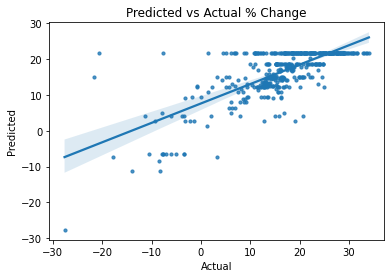

In [209]:
#linear regression model to predict percent change only using destination (total 52 cities) just for fun!
import seaborn as sns

lr_training_model_3 = LinearRegression()
lr_training_model_3.fit(df_for_lg.iloc[:,-52:-1],df_for_lg['% Change'])
training_accuracy_3 = lr_training_model_3.score(df_for_lg.iloc[:,-52:-1],df_for_lg['% Change'])
predicted_y_3 = lr_training_model_3.predict(df_for_lg.iloc[:,-52:-1])

print('Training Accuracy (one hot encoded column = destination city): ' ,training_accuracy_3)
sns.regplot(x = df_for_lg['% Change'],y = predicted_y_3, scatter_kws={"s": 10});
#plt.scatter(df_for_lg['% Change'],predicted_y_3, s = 5);
plt.title('Predicted vs Actual % Change')
plt.xlabel('Actual')
plt.ylabel('Predicted');

#it seems the accuracy is way higher than the first two models even though it uses one categorical variable.
# this results also determines that destination plays a significant factor to determine pre and post percent change.

Training Accuracy (columns = destination city, mean travel time):  0.9037910663104493


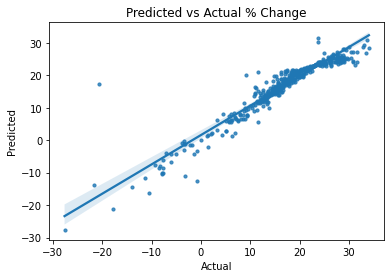

In [210]:
#Linear Regression Model using Mean travel time of Pre and Post and one hot encoded destination cities
columns_improve_model = ['Mean Travel Time (Seconds) Pre','Mean Travel Time (Seconds) Post'] + df_for_lg.iloc[:,-52:-1].columns.to_list()

lr_training_model_4 = LinearRegression()
lr_training_model_4.fit(df_for_lg[columns_improve_model],df_for_lg['% Change'])
training_accuracy_4 = lr_training_model_4.score(df_for_lg[columns_improve_model],df_for_lg['% Change'])
predicted_y_4 = lr_training_model_4.predict(df_for_lg[columns_improve_model])

print('Training Accuracy (columns = destination city, mean travel time): ' ,training_accuracy_4)
sns.regplot(x = df_for_lg['% Change'],y = predicted_y_4, scatter_kws={"s": 10});
#plt.scatter(df_for_lg['% Change'],predicted_y_3, s = 5);
plt.title('Predicted vs Actual % Change')
plt.xlabel('Actual')
plt.ylabel('Predicted');


## Second Exploration: Binary Classification: Within North East and Central East section of San Francisco, Not within the North East and Central East section of San Francisco.


### Dataset Preparation

In [211]:
#Creating Columns with north $ central east sf cities
merged_pre_post_with_NCSF = merged_pre_post.copy()
display_me = merged_pre_post_with_NCSF['Destination Display Name'].str.contains('Pacific Heights|Visitacion Valley|South of Market|Excelsior|Bernal Heights|Bayview|Mission District|Marina District|Tenderloin|Western Addition',
                                                                   regex = True).astype(int)
merged_pre_post_with_NCSF['North & Central East SF'] = display_me
merged_pre_post_with_NCSF.head()

Destination Display Name  \
0   0 Avoca Alley, West of Twin Peaks, San Francisco   
1               0 Bass Court, Bayview, San Francisco   
2     0 Berkeley Way, Diamond Heights, San Francisco   
3          0 Bernard Street, Nob Hill, San Francisco   
4  0 Brookdale Avenue, Visitacion Valley, San Fra...   

   Mean Travel Time (Seconds) Pre  Mean Travel Time (Seconds) Post  \
0                     1016.230769                       847.500000   
1                      999.923077                       699.571429   
2                      948.769231                       788.666667   
3                      507.000000                       367.888889   
4                     1096.000000                       781.000000   

   difference   % Change  North & Central East SF  
0  168.730769  16.603588                        0  
1  300.351648  30.037475                        1  
2  160.102564  16.874764                        0  
3  139.111111  27.438089                        0  
4  315.000000  28.740876                        1

### Baseline Model

coef: [[-0.0484779]] , intercept:  [0.]
accuracy for basic_model_NCSF:  0.7545045045045045


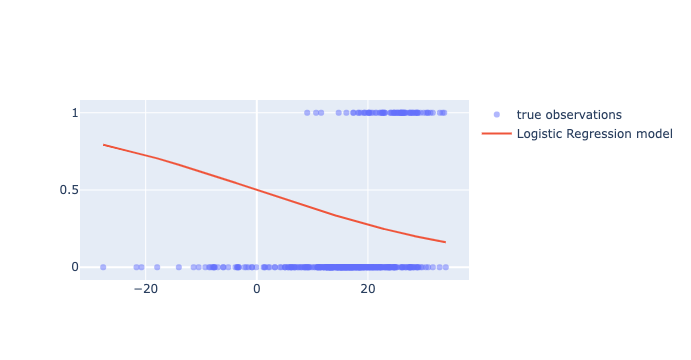

In [212]:
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix


basic_model_NCSF = lm.LogisticRegression(penalty = 'none', fit_intercept = False, solver = 'lbfgs')
basic_model_NCSF.fit(merged_pre_post_with_NCSF[['% Change']], merged_pre_post_with_NCSF['North & Central East SF'])
basic_model_NCSF.predict_proba(merged_pre_post_with_NCSF[['% Change']])

print('coef:', basic_model_NCSF.coef_, ', intercept: ', basic_model_NCSF.intercept_)

y_pred_basic_model_NCSF = basic_model_NCSF.predict(merged_pre_post_with_NCSF[['% Change']])
basic_model_NCSF_accuracy = np.mean(y_pred_basic_model_NCSF == merged_pre_post_with_NCSF['North & Central East SF'])
print('accuracy for basic_model_NCSF: ',basic_model_NCSF_accuracy)

x_sorted_NCSF = np.array(merged_pre_post_with_NCSF['% Change'].sort_values()).reshape(len(merged_pre_post_with_NCSF), 1)
basic_model_ps_sorted_NCSF = basic_model_NCSF.predict_proba(x_sorted_NCSF)[:, 1]

points_NCSF = go.Scatter(name = 'true observations', 
                   x = merged_pre_post_with_NCSF['% Change'],
                   y = merged_pre_post_with_NCSF['North & Central East SF'],
                   mode = 'markers',
                   marker={'opacity':0.5})

lr_line_NCSF = go.Scatter(name = 'Logistic Regression model', 
                    x = x_sorted_NCSF.flatten(),
                    y = basic_model_ps_sorted_NCSF)

fig_NCSF = go.Figure([points_NCSF, lr_line_NCSF])
fig_NCSF

### Confusion Matrix for Baseline Model

[[335  31]
 [ 78   0]]


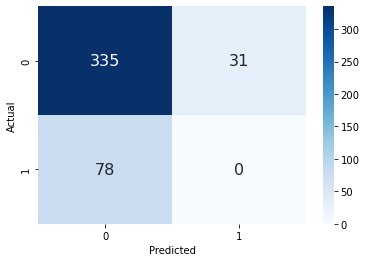

In [213]:
cm_basic_model_NCSF = confusion_matrix(merged_pre_post_with_NCSF['North & Central East SF'],y_pred_basic_model_NCSF)
print(cm_basic_model_NCSF)
sns.heatmap(cm_basic_model_NCSF, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');


#### Model Improvement

coef: [[ 0.01409444 -0.02281338]] , intercept:  [1.65022626]


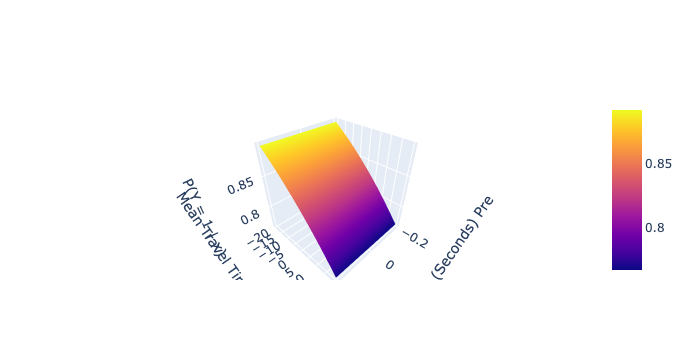

accuracy for better_model_NCSF:  0.8513513513513513
[[337  29]
 [ 37  41]]


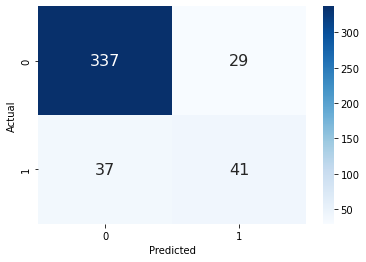

In [214]:
better_model_NCSF = lm.LogisticRegression(penalty = 'none', fit_intercept = True, solver = 'lbfgs')
better_model_NCSF.fit(merged_pre_post_with_NCSF[['Mean Travel Time (Seconds) Pre','Mean Travel Time (Seconds) Post']], merged_pre_post_with_NCSF['North & Central East SF'])
print('coef:', better_model_NCSF.coef_, ', intercept: ', better_model_NCSF.intercept_)

num_points_NCSF = 50 # increase for better resolution, but it will run more slowly. 

# if (num_points <= 100):

uvalues = np.linspace(-0.2, 0.2, num_points_NCSF)
vvalues = np.linspace(-20, 20, num_points_NCSF)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

probs_NCSF = [better_model_NCSF.predict_proba(t.reshape(1, 2))[0, 1] for t in thetas.T]

probs_surface_NCSF = go.Surface(x=u, y=v, z=np.reshape(probs_NCSF, u.shape))

# opt_point = go.Scatter3d(x = [ahat], y = [bhat], z = [mse_for_height_model((ahat, bhat))],
#             mode = 'markers', name = 'optimal parameters',
#             marker=dict(size=10, color='gold'))

fig = go.Figure(data=[probs_surface_NCSF])
# fig.add_trace(opt_point)

fig.update_layout(scene = dict(
    xaxis_title = 'Mean Travel Time (Seconds) Pre',
    yaxis_title = 'Mean Travel Time (Seconds) Post',
    zaxis_title = "P(Y = 1 | x)"))


fig.show()


y_pred_better_model_NCSF = better_model_NCSF.predict(merged_pre_post_with_NCSF[['Mean Travel Time (Seconds) Pre','Mean Travel Time (Seconds) Post']])
better_model_NCSF_accuracy = np.mean(y_pred_better_model_NCSF == merged_pre_post_with_NCSF['North & Central East SF'])
print('accuracy for better_model_NCSF: ',better_model_NCSF_accuracy)



cm_better_model_NCSF = confusion_matrix(merged_pre_post_with_NCSF['North & Central East SF'],y_pred_better_model_NCSF)
print(cm_better_model_NCSF)
sns.heatmap(cm_better_model_NCSF, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');


## Third Exploration: Classifying 52 destination cities

### Data Preparation

In [217]:
final_decision_tree_df.head(2)

Destination Display Name  \
0  0 Avoca Alley, West of Twin Peaks, San Francisco   
1              0 Bass Court, Bayview, San Francisco   

   Mean Travel Time (Seconds) Pre  \
0                     1016.230769   
1                      999.923077   

   Range - Lower Bound Travel Time (Seconds) Pre  \
0                                     779.692308   
1                                     742.615385   

   Range - Upper Bound Travel Time (Seconds)_Pre  \
0                                    1328.538462   
1                                    1348.769231   

   Mean Travel Time (Seconds) Post  \
0                       847.500000   
1                       699.571429   

   Range - Lower Bound Travel Time (Seconds) Post  \
0                                      662.500000   
1                                      579.428571   

   Range - Upper Bound Travel Time (Seconds)_Post  \
0                                     1083.000000   
1                                      858.642857   

   Number of Total Rides Pre Lock Down Destination City  Bay Bridge  \
0                                 13.0    San Francisco           0   
1                                 13.0    San Francisco           0   

   Golden Gate Bridge  San Mateo Hayward Bridge  
0                   0                         0  
1                   0                         0

### Baseline Model

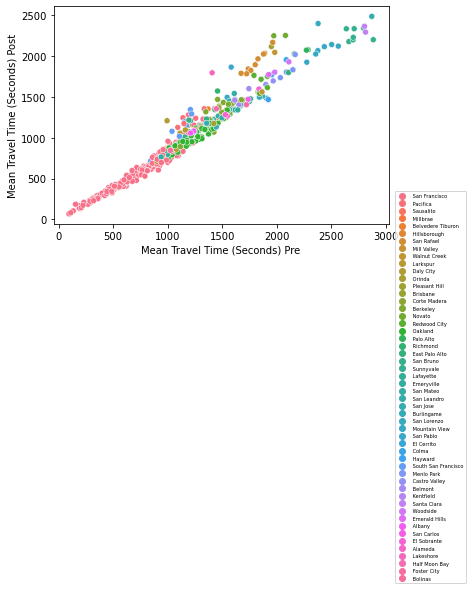

In [218]:
from sklearn.pipeline import Pipeline

np.random.seed(23)

sns.scatterplot(data = final_decision_tree_df, x = "Mean Travel Time (Seconds) Pre", y="Mean Travel Time (Seconds) Post", hue="Destination City");
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0, fontsize = '5');


two features' accuracy:  0.4888888888888889


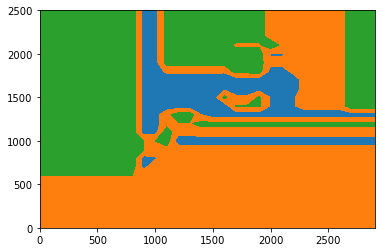

In [219]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train_decision_tree_df, test_decision_tree_df = train_test_split(final_decision_tree_df, test_size=0.1, random_state=42)

decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model = decision_tree_model.fit(train_decision_tree_df[['Mean Travel Time (Seconds) Pre',"Mean Travel Time (Seconds) Post"]],
                                              train_decision_tree_df["Destination City"])
decision_tree_model_accuracy = accuracy_score(decision_tree_model.predict(test_decision_tree_df[['Mean Travel Time (Seconds) Pre',"Mean Travel Time (Seconds) Post"]]),
                                                                          test_decision_tree_df["Destination City"])


#decision tree model using two features (pre and post lock down mean travel time)
print("two features' accuracy: ", decision_tree_model_accuracy)


from matplotlib.colors import ListedColormap
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 3000, 100),
                     np.arange(0, 2600, 100))

Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
#sns.scatterplot(data = final_decision_tree_df, x = "Mean Travel Time (Seconds) Pre", y="Mean Travel Time (Seconds) Post", hue="Destination City");
plt.contourf(xx, yy, Z_int, cmap=sns_cmap);
# fig = plt.gcf()
# fig.savefig("iris_sepal_decision_boundaries_no_data.png", dpi=300, bbox_inches = "tight")




### Model Improvement

In [220]:
#more features
second_decision_tree_model = tree.DecisionTreeClassifier()
second_decision_tree_model = second_decision_tree_model.fit(train_decision_tree_df[['Mean Travel Time (Seconds) Pre','Range - Lower Bound Travel Time (Seconds) Pre','Range - Upper Bound Travel Time (Seconds)_Pre','Mean Travel Time (Seconds) Post','Range - Lower Bound Travel Time (Seconds) Post','Range - Upper Bound Travel Time (Seconds)_Post',
                                                                                    'Number of Total Rides Pre Lock Down']],train_decision_tree_df["Destination City"])

print('accuracy score for more features',accuracy_score(second_decision_tree_model.predict(test_decision_tree_df[['Mean Travel Time (Seconds) Pre','Range - Lower Bound Travel Time (Seconds) Pre','Range - Upper Bound Travel Time (Seconds)_Pre','Mean Travel Time (Seconds) Post','Range - Lower Bound Travel Time (Seconds) Post','Range - Upper Bound Travel Time (Seconds)_Post',
                                                                                    'Number of Total Rides Pre Lock Down']]), test_decision_tree_df["Destination City"]))


#accuracy got higher by adding more features



accuracy score for more features 0.5333333333333333


In [221]:
third_decision_tree_model = tree.DecisionTreeClassifier()
third_decision_tree_model = third_decision_tree_model.fit(train_decision_tree_df[['Mean Travel Time (Seconds) Pre','Range - Lower Bound Travel Time (Seconds) Pre','Range - Upper Bound Travel Time (Seconds)_Pre','Mean Travel Time (Seconds) Post','Range - Lower Bound Travel Time (Seconds) Post','Range - Upper Bound Travel Time (Seconds)_Post',
                                                                                    'Number of Total Rides Pre Lock Down',
                                                                                 'Bay Bridge','Golden Gate Bridge','San Mateo Hayward Bridge']],train_decision_tree_df["Destination City"])

print('accuracy score for more features',accuracy_score(third_decision_tree_model.predict(test_decision_tree_df[['Mean Travel Time (Seconds) Pre','Range - Lower Bound Travel Time (Seconds) Pre','Range - Upper Bound Travel Time (Seconds)_Pre','Mean Travel Time (Seconds) Post','Range - Lower Bound Travel Time (Seconds) Post','Range - Upper Bound Travel Time (Seconds)_Post',
                                                                                    'Number of Total Rides Pre Lock Down',
                                                                                 'Bay Bridge','Golden Gate Bridge','San Mateo Hayward Bridge']]), test_decision_tree_df["Destination City"]))


accuracy score for more features 0.6666666666666666


Since there are 52 different destinations, it is hard to visualize the decision boundaries. We concluded that it is not a good idea to construct a model that classifies 52 different destination cities. 

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [222]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results:
    q4ai3 - 1 result:
        Test case passed!

    q4ai3 - 2 result:
        Trying:
            y_train.shape == (1705,)
        Expecting:
            True
        **********************************************************************
   

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()